# Project 6 - Intro to Deep Learning Image Classification

### Due Date: *Wednesday, April 17th*

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">30 mins</span>
2. Part B - Neural Network Architecture: <span style="color:red;">30 min</span>
3. Part C - Network Training: <span style="color:red;">16 hrs 45 min</span>
4. Part D - Testing: <span style="color:red;">20 min</span>
5. Write-up: <span style="color:red;">40 min</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj6-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorches `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# !wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
  
# !tar xvfz cars_train.tgz
# !tar xvfz cars_test.tgz

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from random import randint
import pandas as pd

    
root = "./"
train_folder_path = root + "cars_train/"
test_folder_path = root + "cars_test/"
train_json_path = root + "train_annos.json"
test_json_path = root + "test_annos.json"

myTransform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Reflection data augmentation dataset which flips images over y axis in addition to providing original images
class ReflectionDataset(Dataset):
  def __init__(self, json_path, image_folder_path, transform=None):
        super(ReflectionDataset, self).__init__()

        with open(json_path) as f:
          self.image_list = list(json.load(f).items())
          
        self.image_folder_path = image_folder_path
        self.transform = transform

  def __getitem__(self, idx):
    flip = False
    if idx >= len(self.image_list):
      idx -= len(self.image_list)
      flip = True
      
    imgName, label = self.image_list[idx]
    image = Image.open(os.path.join(self.image_folder_path, imgName)).convert('RGB')  
    
    if flip:
      image = image.transpose(Image.FLIP_LEFT_RIGHT)

    if self.transform:
      image = self.transform(image)
    return image, label-1

  def __len__(self):
    return len(self.image_list) * 2


#Random crop augmentation dataset which takes random windows of images as well as provides original images
class RandomCropDataset(Dataset):
  def __init__(self, json_path, image_folder_path, transform=None):
        super(RandomCropDataset, self).__init__()

        with open(json_path) as f:
          self.image_list = list(json.load(f).items())
          
        self.image_folder_path = image_folder_path
        self.transform = transform

  def __getitem__(self, idx):
    cropped = False
    
    if idx/4 != int(idx/4):
      cropped = True
    
    idx = int(idx/4)
    
    imgName, label = self.image_list[idx]
    image = Image.open(os.path.join(self.image_folder_path, imgName)).convert('RGB')  
    
    if cropped:
      width, height = image.size
      start_x = randint(0, int(width * 0.25))
      start_y = randint(0, int(height * 0.25))
      end_x = start_x + int(width * 0.75)
      end_y = start_y + int(height * 0.75)
      image = image.crop((start_x, start_y, end_x, end_y))

    if self.transform:
      image = self.transform(image)
    return image, label-1

  def __len__(self):
    return len(self.image_list) * 4


#Normal dataset class which uses original training images
class NormalDataset(Dataset):
    def __init__(self, json_path, image_folder_path, transform=None):
        super(NormalDataset, self).__init__()

        with open(json_path) as f:
          self.image_list = list(json.load(f).items())
          
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __getitem__(self, idx):
      imgName, label = self.image_list[idx]
      
      image = Image.open(os.path.join(self.image_folder_path, imgName)).convert('RGB')
      
      if self.transform:
        image = self.transform(image)
      return image, label-1

    def __len__(self):
      return len(self.image_list)

custom_batch_size = 128
custom_num_workers = 24

# train_dataset = ReflectionDataset(train_json_path, train_folder_path, myTransform)
# train_dataset = RandomCropDataset(train_json_path, train_folder_path, myTransform)
train_dataset = NormalDataset(train_json_path, train_folder_path, myTransform)
test_dataset = NormalDataset(test_json_path, test_folder_path, myTransform)

train_loader = DataLoader(train_dataset, batch_size=custom_batch_size, shuffle=True, num_workers=custom_num_workers)
test_loader = DataLoader(test_dataset, batch_size=custom_batch_size, shuffle=True, num_workers=custom_num_workers)

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermitted downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. an single image with dimensions 224x224 would be `(1, 3, 224, 224)`) and output a vector of shape `(num_classes,)` where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:


In [39]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [40]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implments the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

In [41]:
import torch.nn as nn
import torchvision

class MyNetwork(nn.Module):
  def __init__(self):
    super(MyNetwork, self).__init__()
    # ResNet18
    self.model = torchvision.models.resnet18(pretrained=True)
    self.model.fc = nn.Linear(512, 196)
    
    # AlexNet
#     self.model = torchvision.models.alexnet(pretrained=True)
#     self.model.classifier[6] = nn.Linear(4096, 196)

    # VGG
#     self.model = torchvision.models.vgg16(pretrained=True)
#     self.model.classifier[6] = nn.Linear(4096, 196)
      
  
  def forward(self, x):
    return self.model.forward(x)

model = MyNetwork()
model.cuda()

MyNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

# Part C: Training

Now that you can access your data and you have a network architecture setup, its time to put things together and start training.  Training requires two major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss functions used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer function is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

*note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again*

Finished Training
Epochs trained:  50
Training Time:  5626.744924545288


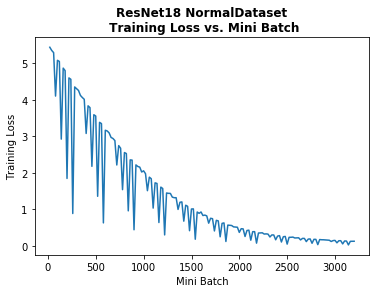

In [54]:
import torch.optim as optim
import time

num_epochs = 50
mini_batch_size = 20
x = []
y = []
k = 0

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train()
start = time.time()
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    #get inputs
    inputs, labels = data
    
    #use GPU
    inputs = inputs.cuda()
    labels = labels.cuda()
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # save losses
    running_loss += loss.item()
    if k % mini_batch_size == mini_batch_size-1:    # save loss every 20 mini-batches
        x.append(k)
        y.append(running_loss / mini_batch_size)
        running_loss = 0.0
    k += 1

end = time.time()  
print('Finished Training')
print("Epochs trained: ", num_epochs)
print("Training Time: ", end - start)

plt.plot(x, y)
plt.title("ResNet18 NormalDataset\n Training Loss vs. Mini Batch", fontweight='bold')
plt.xlabel("Mini Batch")
plt.ylabel("Training Loss")
plt.show()

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will also need to put the model into  you will need to make sure you are not calculating any of the gradients by using `torch.no_grad` in a with statement. You will aslo need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You'll need to extract the guessed class number and compare it with the ground truth number for all images in the test dataset and calculate the overall accuracy.  Print out the overall accuacy your model got. 

In [43]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 66 %


## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [20 pts] Setting up you architecture
* [20 pts] Training your model
* [20 pts] Displaying the accuracy of your model

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!).
* [10 pts] Enhance your dataloader to include random crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. 
* [10 pts] Analyze the effect of learning rates and epochs on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of batch_size and varying optimizers on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.

## Write up

I chose the resnet18 network as a base network and adjusted the output to be 196 output classes instead of 1000. For the last 20 points, I chose to implement the reflection data augmentation and the random crop augmentation. The reflection data augmentation was implemented with the ReflectionDataset class which flips all the images over the y axis as well as provides the original images. The random crop augmentation was implemented with the RandomCropDataset which, in addition to providing the original images, provides three random windows for each image, the windows being 3/4 of the original image size so as not to miss car parts. I trained the ResNet18 on these three datasets with the following parameters: batchsize of 128, number of workers of 24, learning rate of 0.001, momentum term of 0.9, shuffled data, Cross Entropy loss function, Stochastic Gradient Descent optimizer, 50 epochs. Below are the testing accuracies obtained after training for each dataset 

<ul>
  <li>NormalDataset: 66%</li>
  <li>ReflectionDataset: 74%</li>
  <li>RandomCropDataset: 77%</li>
</ul>
And plots of the training losses for the above accuracies are below this cell.
<br><br>

For an additional 10 extra credit points, I chose to analyze the effect of different pretrained networks on the accuracy of the network. In addition to the ResNet18, I tried the AlexNet and VGG on the NormalDataset with all the hyper parameters as before except for a batchsize of 64 instead of 128 previously used because CUDA was throwing errors about not having enough memory to allocate on VGG so halving the batchsize fixed this problem. Note, I ran these networks with identical parameters so as not to introduce any other variation besides the model itself. For AlexNet and VGG, I made sure to modify the appropriate layer at the classification stage, see the MyNetworkClass for details. Below is a bar graph with the overall test accuracy that each network achieved after training on the NormalDataset. What I found from comparing these different networks was AlexNet did the worst by far and took just about as long as the ResNet to train. It's interesting to note that the VGG got the best accuracy by far but also took about 3 times as long to train as the other two nets. If time were an issue, I would choose the ResNet, but if overall accuracy was valued more than time, the VGG is the best bet.
<ul>
  <li>ResNet18: 67%</li>
  <li>AlexNet: 43%</li>
  <li>VGG: 74%</li>
</ul>

Below the bar graph is a plot of training loss of the ResNet18, AlexNet and VGG.

The highest accuracy overall I got was ** 77%** using the RandomCropDataset on the ResNet18.

### Write up plots

NormalDataset accuracy: 66
Training time in seconds: 5626


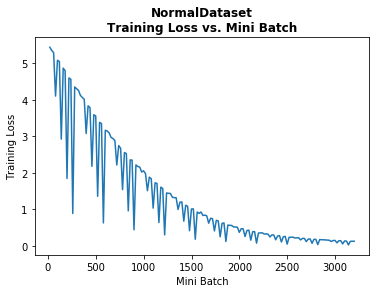

In [55]:
normal_x = [19, 39, 59, 79, 99, 119, 139, 159, 179, 199, 219, 239, 259, 279, 299, 319, 339, 359, 379, 399, 419, 439, 459, 479, 499, 519, 539, 559, 579, 599, 619, 639, 659, 679, 699, 719, 739, 759, 779, 799, 819, 839, 859, 879, 899, 919, 939, 959, 979, 999, 1019, 1039, 1059, 1079, 1099, 1119, 1139, 1159, 1179, 1199, 1219, 1239, 1259, 1279, 1299, 1319, 1339, 1359, 1379, 1399, 1419, 1439, 1459, 1479, 1499, 1519, 1539, 1559, 1579, 1599, 1619, 1639, 1659, 1679, 1699, 1719, 1739, 1759, 1779, 1799, 1819, 1839, 1859, 1879, 1899, 1919, 1939, 1959, 1979, 1999, 2019, 2039, 2059, 2079, 2099, 2119, 2139, 2159, 2179, 2199, 2219, 2239, 2259, 2279, 2299, 2319, 2339, 2359, 2379, 2399, 2419, 2439, 2459, 2479, 2499, 2519, 2539, 2559, 2579, 2599, 2619, 2639, 2659, 2679, 2699, 2719, 2739, 2759, 2779, 2799, 2819, 2839, 2859, 2879, 2899, 2919, 2939, 2959, 2979, 2999, 3019, 3039, 3059, 3079, 3099, 3119, 3139, 3159, 3179, 3199]
normal_y = [5.44219970703125, 5.354531764984131, 5.2943134069442745, 4.10385422706604, 5.0839824914932255, 5.0524450778961185, 2.924440693855286, 4.869791507720947, 4.801415681838989, 1.8464937448501586, 4.60093846321106, 4.563782906532287, 0.8853999137878418, 4.353927254676819, 4.306160259246826, 4.257795834541321, 4.1221092462539675, 4.0642974257469175, 4.01564507484436, 3.0791274666786195, 3.8364574790000914, 3.7867568731307983, 2.177938365936279, 3.5929774403572083, 3.5576659798622132, 1.357180643081665, 3.384436309337616, 3.349151873588562, 0.6285022020339965, 3.167549264431, 3.1468536138534544, 3.094812572002411, 2.9705232262611387, 2.9415467143058778, 2.884450387954712, 2.2155083298683165, 2.7463794589042663, 2.6734267354011534, 1.5394999265670777, 2.5562368035316467, 2.5287209153175354, 0.9583035349845886, 2.3554718852043153, 2.3493473291397096, 0.440030574798584, 2.217611002922058, 2.174232506752014, 2.1564115643501283, 2.023761588335037, 2.055315726995468, 1.9771092414855957, 1.5110604226589204, 1.8820234954357147, 1.8391919791698457, 1.034152889251709, 1.7262430548667909, 1.7090273797512054, 0.638466727733612, 1.609660142660141, 1.5707805633544922, 0.2989282369613647, 1.4482278525829315, 1.4380829453468322, 1.436318975687027, 1.3347114324569702, 1.3186391472816468, 1.3188838481903076, 0.9976849615573883, 1.1930503606796266, 1.203653621673584, 0.6758682489395141, 1.1125377237796783, 1.0834567606449128, 0.41444072127342224, 1.0093495309352876, 1.0123487561941147, 0.18046188950538636, 0.9271284729242325, 0.8905970811843872, 0.9277884662151337, 0.8306424230337143, 0.8419910490512847, 0.8212583899497986, 0.6206662833690644, 0.754920169711113, 0.7440424561500549, 0.4077370077371597, 0.6986352205276489, 0.683788126707077, 0.24749415814876558, 0.6154747158288956, 0.6275347679853439, 0.11902295649051667, 0.5678948193788529, 0.5628358393907547, 0.5570231437683105, 0.5195680975914001, 0.5152006536722183, 0.5094388425350189, 0.3682363525032997, 0.46931667625904083, 0.4645748481154442, 0.25566401332616806, 0.42003621309995653, 0.42924067080020906, 0.1543796628713608, 0.38715979605913164, 0.3889030680060387, 0.07353755384683609, 0.35039602369070055, 0.3550052151083946, 0.3569083198904991, 0.32244675010442736, 0.3276606217026711, 0.32094224244356157, 0.2422978922724724, 0.2984250098466873, 0.2969631180167198, 0.1658911868929863, 0.2669766113162041, 0.2794238939881325, 0.10474080294370651, 0.2492591843008995, 0.25723192617297175, 0.04674752503633499, 0.23309606164693833, 0.2343402773141861, 0.23933218866586686, 0.2151665695011616, 0.21646583750844, 0.22009325549006462, 0.16171852573752404, 0.2035582832992077, 0.20364901870489122, 0.11579766273498535, 0.1844755806028843, 0.18925573155283928, 0.07006464675068855, 0.17827801331877707, 0.1767451860010624, 0.03304137140512466, 0.17189222276210786, 0.166408072412014, 0.16559617668390275, 0.1616522789001465, 0.15486080050468445, 0.15335411503911017, 0.11859540715813637, 0.14350717887282372, 0.14912789016962053, 0.08278278186917305, 0.13960689306259155, 0.14053881727159023, 0.052487405762076375, 0.13288575783371925, 0.13083810731768608, 0.024952488392591475, 0.12329642027616501, 0.12576923929154873, 0.12568080723285674]
normal_accuracy = 66
normal_train_time = 5626

print("NormalDataset accuracy:", normal_accuracy)
print("Training time in seconds:", normal_train_time)

plt.plot(normal_x, normal_y)
plt.title("NormalDataset\nTraining Loss vs. Mini Batch", fontweight='bold')
plt.xlabel("Mini Batch")
plt.ylabel("Training Loss")
plt.show()

ReflectionDataset accuracy: 74 %
Training time: 11215 seconds


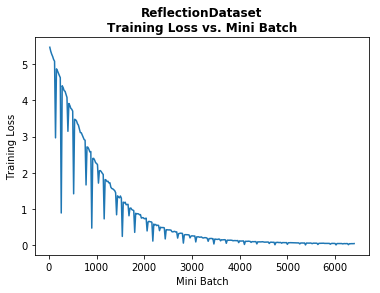

In [53]:
reflection_x = [19, 39, 59, 79, 99, 119, 139, 159, 179, 199, 219, 239, 259, 279, 299, 319, 339, 359, 379, 399, 419, 439, 459, 479, 499, 519, 539, 559, 579, 599, 619, 639, 659, 679, 699, 719, 739, 759, 779, 799, 819, 839, 859, 879, 899, 919, 939, 959, 979, 999, 1019, 1039, 1059, 1079, 1099, 1119, 1139, 1159, 1179, 1199, 1219, 1239, 1259, 1279, 1299, 1319, 1339, 1359, 1379, 1399, 1419, 1439, 1459, 1479, 1499, 1519, 1539, 1559, 1579, 1599, 1619, 1639, 1659, 1679, 1699, 1719, 1739, 1759, 1779, 1799, 1819, 1839, 1859, 1879, 1899, 1919, 1939, 1959, 1979, 1999, 2019, 2039, 2059, 2079, 2099, 2119, 2139, 2159, 2179, 2199, 2219, 2239, 2259, 2279, 2299, 2319, 2339, 2359, 2379, 2399, 2419, 2439, 2459, 2479, 2499, 2519, 2539, 2559, 2579, 2599, 2619, 2639, 2659, 2679, 2699, 2719, 2739, 2759, 2779, 2799, 2819, 2839, 2859, 2879, 2899, 2919, 2939, 2959, 2979, 2999, 3019, 3039, 3059, 3079, 3099, 3119, 3139, 3159, 3179, 3199, 3219, 3239, 3259, 3279, 3299, 3319, 3339, 3359, 3379, 3399, 3419, 3439, 3459, 3479, 3499, 3519, 3539, 3559, 3579, 3599, 3619, 3639, 3659, 3679, 3699, 3719, 3739, 3759, 3779, 3799, 3819, 3839, 3859, 3879, 3899, 3919, 3939, 3959, 3979, 3999, 4019, 4039, 4059, 4079, 4099, 4119, 4139, 4159, 4179, 4199, 4219, 4239, 4259, 4279, 4299, 4319, 4339, 4359, 4379, 4399, 4419, 4439, 4459, 4479, 4499, 4519, 4539, 4559, 4579, 4599, 4619, 4639, 4659, 4679, 4699, 4719, 4739, 4759, 4779, 4799, 4819, 4839, 4859, 4879, 4899, 4919, 4939, 4959, 4979, 4999, 5019, 5039, 5059, 5079, 5099, 5119, 5139, 5159, 5179, 5199, 5219, 5239, 5259, 5279, 5299, 5319, 5339, 5359, 5379, 5399, 5419, 5439, 5459, 5479, 5499, 5519, 5539, 5559, 5579, 5599, 5619, 5639, 5659, 5679, 5699, 5719, 5739, 5759, 5779, 5799, 5819, 5839, 5859, 5879, 5899, 5919, 5939, 5959, 5979, 5999, 6019, 6039, 6059, 6079, 6099, 6119, 6139, 6159, 6179, 6199, 6219, 6239, 6259, 6279, 6299, 6319, 6339, 6359, 6379, 6399]
reflection_y = [5.463751482963562, 5.352384567260742, 5.271540856361389, 5.209014177322388, 5.126841902732849, 5.078340983390808, 2.9637811183929443, 4.867243862152099, 4.8156485080719, 4.748926877975464, 4.685954689979553, 4.624290633201599, 0.890492057800293, 4.400429749488831, 4.3499547958374025, 4.26682562828064, 4.248714923858643, 4.163147735595703, 4.079661655426025, 3.1442691802978517, 3.911451530456543, 3.858602452278137, 3.7797827243804933, 3.753453183174133, 3.702129578590393, 1.4201013684272765, 3.47643666267395, 3.464229929447174, 3.4300578832626343, 3.3543958187103273, 3.3132381796836854, 3.2151170492172243, 3.1090924739837646, 3.104775643348694, 3.0412578105926515, 2.984891414642334, 2.917201566696167, 2.8987303376197815, 1.6645675897598267, 2.7146885633468627, 2.70286830663681, 2.646971333026886, 2.5744186878204345, 2.586955261230469, 0.4731157302856445, 2.395271193981171, 2.397694480419159, 2.3506107211112974, 2.2788769483566282, 2.258389723300934, 2.2238744854927064, 1.7153366565704347, 2.0565025448799132, 2.0610871732234957, 2.0292376101017, 1.9867748379707337, 1.953906100988388, 0.7281926512718201, 1.814100706577301, 1.7990893065929412, 1.7583983302116395, 1.7662378013134004, 1.7204614996910095, 1.7245936274528504, 1.6018488466739655, 1.5660692393779754, 1.5569784700870515, 1.5349201917648316, 1.5094496130943298, 1.4511514604091644, 0.8417047142982483, 1.3638471066951752, 1.3336562275886537, 1.3090537786483765, 1.3596293330192566, 1.299561333656311, 0.24441714882850646, 1.1899795889854432, 1.1684576213359832, 1.1893884539604187, 1.1194110810756683, 1.125282996892929, 1.1297029256820679, 0.8139495193958283, 1.0232340842485428, 1.0267353028059005, 0.9842159807682037, 0.9703591167926788, 0.9577312499284745, 0.3562621772289276, 0.8831194281578064, 0.868284797668457, 0.8720612496137619, 0.8667141020298004, 0.8426078498363495, 0.8465344697237015, 0.750161561369896, 0.7623847991228103, 0.7596267908811569, 0.732751214504242, 0.737230372428894, 0.7486755341291428, 0.39545583724975586, 0.6441258609294891, 0.6618511348962783, 0.6484913527965546, 0.6491027623414993, 0.6345224022865296, 0.11552377343177796, 0.5851396679878235, 0.5641543060541153, 0.5748291969299316, 0.543021847307682, 0.5540777236223221, 0.5487839221954346, 0.4037355124950409, 0.49842025339603424, 0.4884858995676041, 0.4872917696833611, 0.4890675649046898, 0.48005963414907454, 0.17519473284482956, 0.4286247968673706, 0.42931163907051084, 0.423368301987648, 0.42576933056116106, 0.422415192425251, 0.4185415282845497, 0.37454172521829604, 0.3701135143637657, 0.380397367477417, 0.3836118966341019, 0.36510020941495896, 0.3708106234669685, 0.19851695001125336, 0.32049614638090135, 0.32884264290332793, 0.33464081585407257, 0.3326503664255142, 0.32807912677526474, 0.06028909236192703, 0.2858026325702667, 0.2938331410288811, 0.2927020713686943, 0.2915808901190758, 0.2900569409132004, 0.2846307702362537, 0.2047043152153492, 0.2532476633787155, 0.2610631950199604, 0.2568599693477154, 0.2553584545850754, 0.256380894780159, 0.09207150712609291, 0.2319300390779972, 0.23405857756733894, 0.23370113745331764, 0.2221356064081192, 0.22542528286576272, 0.22960669472813605, 0.20710285007953644, 0.20149185955524446, 0.20979598835110663, 0.21051089763641356, 0.20686062052845955, 0.19244558960199357, 0.11049665808677674, 0.18583566471934318, 0.18406157493591307, 0.19114575609564782, 0.1833277501165867, 0.18357177153229715, 0.0359244592487812, 0.17281701415777206, 0.1662715420126915, 0.16542374193668366, 0.162551898509264, 0.17184288278222085, 0.16746595799922942, 0.12306988164782524, 0.15345879048109054, 0.14877058565616608, 0.15233202055096626, 0.1544671505689621, 0.1493637390434742, 0.054705244675278666, 0.14125150963664054, 0.13942381590604783, 0.1386615876108408, 0.1416491311043501, 0.13964554406702517, 0.13745452128350735, 0.12461658790707589, 0.129464939981699, 0.13010606467723845, 0.12728427052497865, 0.12662707641720772, 0.130608232319355, 0.07407057918608188, 0.121842385455966, 0.11581427380442619, 0.1166014712303877, 0.11535717248916626, 0.11988407596945763, 0.02271702215075493, 0.10981319434940814, 0.10906596295535564, 0.10866777710616589, 0.11379573047161103, 0.108875123411417, 0.10683261416852474, 0.08028044290840626, 0.10147575214505196, 0.0990398433059454, 0.10048380382359028, 0.10263044051826001, 0.1015034981071949, 0.03855103813111782, 0.09573112614452839, 0.0933288536965847, 0.09514614827930927, 0.09297636710107327, 0.0949119407683611, 0.09792136996984482, 0.09117720872163773, 0.086350604519248, 0.0873816542327404, 0.08910471983253956, 0.08737705089151859, 0.08985981903970242, 0.05020720027387142, 0.08301669433712959, 0.08542467914521694, 0.08286747373640538, 0.08125245533883571, 0.08393670246005058, 0.014958368614315987, 0.07933902367949486, 0.07721801549196243, 0.08293521218001842, 0.07449526339769363, 0.0772389754652977, 0.0784901525825262, 0.05749902315437794, 0.07493069991469384, 0.07395019046962262, 0.07352682650089264, 0.07227080129086971, 0.0747393887490034, 0.02612330988049507, 0.07093847207725049, 0.06993646062910557, 0.07240631468594075, 0.0712212860584259, 0.06814640574157238, 0.06975106820464134, 0.06729013100266457, 0.0655752919614315, 0.06750383786857128, 0.06630586627870798, 0.06630183663219213, 0.06504831537604332, 0.038297781348228456, 0.06270393673330546, 0.06318072900176049, 0.06308828350156545, 0.061040107533335684, 0.06386098116636277, 0.010582323372364043, 0.06120555233210325, 0.060300908982753754, 0.06197256185114384, 0.059355925768613815, 0.06269100606441498, 0.058293943479657176, 0.04461190290749073, 0.05811733230948448, 0.057820852100849154, 0.05805798545479775, 0.05836246218532324, 0.05720050483942032, 0.02163650989532471, 0.053643517568707465, 0.0541249692440033, 0.053561972454190254, 0.05641569271683693, 0.055264879018068314, 0.0573873944580555, 0.05213971138000488, 0.052506293170154095, 0.05253284759819508, 0.05154905952513218, 0.05395888686180115, 0.05198938865214586, 0.02976861149072647, 0.04887184090912342, 0.052207129821181295, 0.05101214498281479, 0.0498065035790205, 0.050537094473838806, 0.010286006331443786, 0.04822642132639885, 0.04813903421163559, 0.04794767983257771, 0.0485800925642252, 0.04783625490963459, 0.04794845804572105, 0.038428034633398056, 0.04535616636276245, 0.04734482541680336, 0.044193027541041374, 0.04734253138303757, 0.04602405354380608, 0.016815899312496184, 0.04402172975242138, 0.04261344633996487, 0.045210637897253034, 0.044026825949549674, 0.04448657892644405, 0.047349602356553076]
reflection_accuracy = 74
reflection_train_time = 11215

print("ReflectionDataset accuracy:", reflection_accuracy, "%")
print("Training time:", reflection_train_time, "seconds")

plt.plot(reflection_x, reflection_y)
plt.title("ReflectionDataset\nTraining Loss vs. Mini Batch", fontweight='bold')
plt.xlabel("Mini Batch")
plt.ylabel("Training Loss")
plt.show()

RandomCropDataset accuracy: 77 %
Training time: 17274 seconds


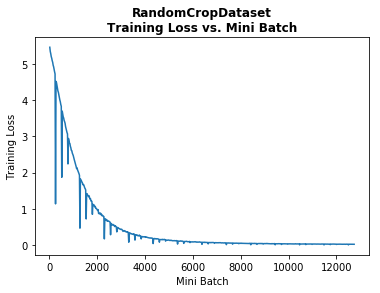

In [46]:
random_crop_x = [19, 39, 59, 79, 99, 119, 139, 159, 179, 199, 219, 239, 259, 279, 299, 319, 339, 359, 379, 399, 419, 439, 459, 479, 499, 519, 539, 559, 579, 599, 619, 639, 659, 679, 699, 719, 739, 759, 779, 799, 819, 839, 859, 879, 899, 919, 939, 959, 979, 999, 1019, 1039, 1059, 1079, 1099, 1119, 1139, 1159, 1179, 1199, 1219, 1239, 1259, 1279, 1299, 1319, 1339, 1359, 1379, 1399, 1419, 1439, 1459, 1479, 1499, 1519, 1539, 1559, 1579, 1599, 1619, 1639, 1659, 1679, 1699, 1719, 1739, 1759, 1779, 1799, 1819, 1839, 1859, 1879, 1899, 1919, 1939, 1959, 1979, 1999, 2019, 2039, 2059, 2079, 2099, 2119, 2139, 2159, 2179, 2199, 2219, 2239, 2259, 2279, 2299, 2319, 2339, 2359, 2379, 2399, 2419, 2439, 2459, 2479, 2499, 2519, 2539, 2559, 2579, 2599, 2619, 2639, 2659, 2679, 2699, 2719, 2739, 2759, 2779, 2799, 2819, 2839, 2859, 2879, 2899, 2919, 2939, 2959, 2979, 2999, 3019, 3039, 3059, 3079, 3099, 3119, 3139, 3159, 3179, 3199, 3219, 3239, 3259, 3279, 3299, 3319, 3339, 3359, 3379, 3399, 3419, 3439, 3459, 3479, 3499, 3519, 3539, 3559, 3579, 3599, 3619, 3639, 3659, 3679, 3699, 3719, 3739, 3759, 3779, 3799, 3819, 3839, 3859, 3879, 3899, 3919, 3939, 3959, 3979, 3999, 4019, 4039, 4059, 4079, 4099, 4119, 4139, 4159, 4179, 4199, 4219, 4239, 4259, 4279, 4299, 4319, 4339, 4359, 4379, 4399, 4419, 4439, 4459, 4479, 4499, 4519, 4539, 4559, 4579, 4599, 4619, 4639, 4659, 4679, 4699, 4719, 4739, 4759, 4779, 4799, 4819, 4839, 4859, 4879, 4899, 4919, 4939, 4959, 4979, 4999, 5019, 5039, 5059, 5079, 5099, 5119, 5139, 5159, 5179, 5199, 5219, 5239, 5259, 5279, 5299, 5319, 5339, 5359, 5379, 5399, 5419, 5439, 5459, 5479, 5499, 5519, 5539, 5559, 5579, 5599, 5619, 5639, 5659, 5679, 5699, 5719, 5739, 5759, 5779, 5799, 5819, 5839, 5859, 5879, 5899, 5919, 5939, 5959, 5979, 5999, 6019, 6039, 6059, 6079, 6099, 6119, 6139, 6159, 6179, 6199, 6219, 6239, 6259, 6279, 6299, 6319, 6339, 6359, 6379, 6399, 6419, 6439, 6459, 6479, 6499, 6519, 6539, 6559, 6579, 6599, 6619, 6639, 6659, 6679, 6699, 6719, 6739, 6759, 6779, 6799, 6819, 6839, 6859, 6879, 6899, 6919, 6939, 6959, 6979, 6999, 7019, 7039, 7059, 7079, 7099, 7119, 7139, 7159, 7179, 7199, 7219, 7239, 7259, 7279, 7299, 7319, 7339, 7359, 7379, 7399, 7419, 7439, 7459, 7479, 7499, 7519, 7539, 7559, 7579, 7599, 7619, 7639, 7659, 7679, 7699, 7719, 7739, 7759, 7779, 7799, 7819, 7839, 7859, 7879, 7899, 7919, 7939, 7959, 7979, 7999, 8019, 8039, 8059, 8079, 8099, 8119, 8139, 8159, 8179, 8199, 8219, 8239, 8259, 8279, 8299, 8319, 8339, 8359, 8379, 8399, 8419, 8439, 8459, 8479, 8499, 8519, 8539, 8559, 8579, 8599, 8619, 8639, 8659, 8679, 8699, 8719, 8739, 8759, 8779, 8799, 8819, 8839, 8859, 8879, 8899, 8919, 8939, 8959, 8979, 8999, 9019, 9039, 9059, 9079, 9099, 9119, 9139, 9159, 9179, 9199, 9219, 9239, 9259, 9279, 9299, 9319, 9339, 9359, 9379, 9399, 9419, 9439, 9459, 9479, 9499, 9519, 9539, 9559, 9579, 9599, 9619, 9639, 9659, 9679, 9699, 9719, 9739, 9759, 9779, 9799, 9819, 9839, 9859, 9879, 9899, 9919, 9939, 9959, 9979, 9999, 10019, 10039, 10059, 10079, 10099, 10119, 10139, 10159, 10179, 10199, 10219, 10239, 10259, 10279, 10299, 10319, 10339, 10359, 10379, 10399, 10419, 10439, 10459, 10479, 10499, 10519, 10539, 10559, 10579, 10599, 10619, 10639, 10659, 10679, 10699, 10719, 10739, 10759, 10779, 10799, 10819, 10839, 10859, 10879, 10899, 10919, 10939, 10959, 10979, 10999, 11019, 11039, 11059, 11079, 11099, 11119, 11139, 11159, 11179, 11199, 11219, 11239, 11259, 11279, 11299, 11319, 11339, 11359, 11379, 11399, 11419, 11439, 11459, 11479, 11499, 11519, 11539, 11559, 11579, 11599, 11619, 11639, 11659, 11679, 11699, 11719, 11739, 11759, 11779, 11799, 11819, 11839, 11859, 11879, 11899, 11919, 11939, 11959, 11979, 11999, 12019, 12039, 12059, 12079, 12099, 12119, 12139, 12159, 12179, 12199, 12219, 12239, 12259, 12279, 12299, 12319, 12339, 12359, 12379, 12399, 12419, 12439, 12459, 12479, 12499, 12519, 12539, 12559, 12579, 12599, 12619, 12639, 12659, 12679, 12699, 12719, 12739]
random_crop_y = [5.45431661605835, 5.338423109054565, 5.277034163475037, 5.19811475276947, 5.152552390098572, 5.086717414855957, 5.040792632102966, 4.960465788841248, 4.916494154930115, 4.843201613426208, 4.777678108215332, 4.718130278587341, 1.1371810674667358, 4.512928891181946, 4.4777124404907225, 4.3964667320251465, 4.311216807365417, 4.2477863073349, 4.208291363716126, 4.137480449676514, 4.072557544708252, 4.000155663490295, 3.9495190382003784, 3.874162232875824, 3.8260063886642457, 1.86919162273407, 3.6942503571510317, 3.6122300744056703, 3.537001097202301, 3.5042436599731444, 3.4353460311889648, 3.4013769388198853, 3.3553104758262635, 3.2669296741485594, 3.21027010679245, 3.1407931089401244, 3.1011465549468995, 3.065531516075134, 2.2378470301628113, 2.94075208902359, 2.872371160984039, 2.817801797389984, 2.7988309979438784, 2.7244147777557375, 2.682132601737976, 2.610712945461273, 2.603961372375488, 2.5382548928260804, 2.5037503838539124, 2.4689273953437807, 2.4113000631332397, 2.362915778160095, 2.3147998690605163, 2.273867630958557, 2.224257206916809, 2.168156921863556, 2.110226058959961, 2.126816976070404, 2.074168312549591, 2.039308267831802, 2.0072657227516175, 1.9704098165035249, 1.9237301409244538, 0.4680592894554138, 1.8245767533779145, 1.784603202342987, 1.774294900894165, 1.742212051153183, 1.7216517746448516, 1.6659940838813783, 1.6728784203529359, 1.6592422246932983, 1.61857790350914, 1.577418726682663, 1.5544850945472717, 1.5203048467636109, 0.7216716170310974, 1.420402282476425, 1.412360817193985, 1.3747775733470917, 1.3690047204494475, 1.3355580627918244, 1.3610385954380035, 1.3151575207710267, 1.271073931455612, 1.2822640657424926, 1.216192352771759, 1.2171667695045472, 1.2023486852645875, 0.8488040149211884, 1.126114073395729, 1.1088644206523894, 1.1154488235712052, 1.0753333389759063, 1.0570972174406053, 1.0701219856739044, 1.012960782647133, 1.0116328120231628, 1.0000232875347137, 0.9741608291864395, 0.9536146938800811, 0.9781896203756333, 0.8701416850090027, 0.8750807672739029, 0.88187555372715, 0.8525979697704316, 0.8814302951097488, 0.836651748418808, 0.8513363361358642, 0.8103946566581726, 0.8198788434267044, 0.811580365896225, 0.7916419267654419, 0.7887185275554657, 0.17164123952388763, 0.7313843369483948, 0.7101731151342392, 0.6881396234035492, 0.7080178797245026, 0.7001169621944427, 0.6592711299657822, 0.6766684085130692, 0.6641253113746644, 0.661376741528511, 0.6540093302726746, 0.6415909320116043, 0.6327743202447891, 0.28637684881687164, 0.5994908347725868, 0.5843986183404922, 0.5572696581482888, 0.5596959754824639, 0.5702759176492691, 0.5517008155584335, 0.5385216474533081, 0.5445211827754974, 0.5104894444346428, 0.5314451336860657, 0.5168683961033821, 0.5018312081694603, 0.3649821221828461, 0.4893916264176369, 0.4783639445900917, 0.48079710453748703, 0.4576413884758949, 0.45611284822225573, 0.45401143580675124, 0.4358025848865509, 0.43556748777627946, 0.4320503145456314, 0.4390664756298065, 0.42171152532100675, 0.40852302461862566, 0.37844072431325915, 0.394448946416378, 0.40106607377529147, 0.3950982928276062, 0.3787571355700493, 0.38470997363328935, 0.36712710112333297, 0.3662155032157898, 0.3702802374958992, 0.3547206804156303, 0.36530461460351943, 0.3409892410039902, 0.08100626468658448, 0.31539472490549086, 0.3443843126296997, 0.32427210211753843, 0.3134777098894119, 0.3182601898908615, 0.3132525056600571, 0.3016015633940697, 0.30452439486980437, 0.3059436768293381, 0.29244687110185624, 0.3067504346370697, 0.2969939649105072, 0.13852770626544952, 0.2838767282664776, 0.2731281705200672, 0.2835848145186901, 0.27185412049293517, 0.27606341019272806, 0.2578126221895218, 0.2560000717639923, 0.2594315029680729, 0.2784841813147068, 0.2528186790645123, 0.25100688710808755, 0.25565702840685844, 0.172575593739748, 0.23227324336767197, 0.23193796202540398, 0.23559895232319833, 0.23124558106064796, 0.22776797860860826, 0.22842274382710456, 0.23340237513184547, 0.22519958391785622, 0.21511653959751129, 0.22923865914344788, 0.21694256961345673, 0.2183787815272808, 0.21158810704946518, 0.2096713274717331, 0.20480553060770035, 0.20062268674373626, 0.1987519569694996, 0.19606202095746994, 0.20029882937669755, 0.19423492774367332, 0.1932862050831318, 0.1980733945965767, 0.1924458086490631, 0.18406868875026702, 0.042666462063789365, 0.1764521926641464, 0.18291555419564248, 0.17909647449851035, 0.18033867776393891, 0.1747198797762394, 0.16947583258152008, 0.17763576358556749, 0.17292602807283403, 0.1752335637807846, 0.17298782840371132, 0.16349925622344016, 0.16379822492599488, 0.08110066652297973, 0.1517169199883938, 0.15357156544923783, 0.15358464270830155, 0.15269840322434902, 0.14979633465409278, 0.1608748219907284, 0.15164242684841156, 0.1477341301739216, 0.15519570484757422, 0.15905789621174335, 0.15362281240522863, 0.15018355399370192, 0.11084458529949189, 0.13651203438639642, 0.14135032668709754, 0.13425146490335466, 0.1347675111144781, 0.14021870121359825, 0.1387995358556509, 0.13989364095032214, 0.13056970313191413, 0.13021543733775615, 0.12852779738605022, 0.13669831939041616, 0.132432833686471, 0.12777828760445117, 0.1207881212234497, 0.12312493808567523, 0.12197603844106197, 0.1212962307035923, 0.12328652292490005, 0.12516835927963257, 0.11783710345625878, 0.12164760604500771, 0.12297734916210175, 0.12453170455992221, 0.11827382929623127, 0.02898540087044239, 0.10785774886608124, 0.11214179284870625, 0.11056829020380973, 0.106953040137887, 0.11057751923799515, 0.11760924570262432, 0.11383450701832772, 0.10751642920076847, 0.11336552053689956, 0.1106308676302433, 0.10510792024433613, 0.10246285758912563, 0.04790821298956871, 0.09968227557837964, 0.09990036599338055, 0.09802895784378052, 0.10071873031556607, 0.10465222410857677, 0.10537941344082355, 0.10058138035237789, 0.0938933439552784, 0.09441800341010094, 0.09651457667350768, 0.09476707503199577, 0.10181490033864975, 0.07028047405183316, 0.09190837889909745, 0.08960709236562252, 0.08827851749956608, 0.08683723397552967, 0.09148827567696571, 0.08779282122850418, 0.08942824602127075, 0.08726780116558075, 0.09223821461200714, 0.09127831049263477, 0.09390396326780319, 0.08892937153577804, 0.08285939767956733, 0.08778797090053558, 0.08138794377446175, 0.084697500243783, 0.08236758708953858, 0.0842429243028164, 0.08646556027233601, 0.08878006376326084, 0.08246692679822445, 0.08104872964322567, 0.07738465443253517, 0.0780250508338213, 0.02153334952890873, 0.0779910683631897, 0.07898071594536304, 0.07711503468453884, 0.07554345652461052, 0.08055853471159935, 0.07116037718951702, 0.07632852010428906, 0.07583983093500138, 0.0747862283140421, 0.07751403450965881, 0.07222390323877334, 0.07225976083427668, 0.03519081994891167, 0.0722267348319292, 0.07043743096292018, 0.0703354761004448, 0.07203999869525432, 0.06731296628713608, 0.07195312865078449, 0.06935924366116523, 0.07289091609418392, 0.07248157486319542, 0.06932384017854928, 0.07155073322355747, 0.07001617141067981, 0.04979935437440872, 0.06373775824904442, 0.06635310351848603, 0.06920122653245926, 0.06492306292057037, 0.0666391171514988, 0.06512242034077645, 0.06526548061519861, 0.06422013454139233, 0.06764410194009543, 0.06611818876117467, 0.06889056265354157, 0.06868974715471268, 0.0640710562467575, 0.06257489118725061, 0.061171144247055054, 0.06393874064087868, 0.06364498101174831, 0.060603171586990356, 0.06046197842806578, 0.05913067702203989, 0.06401608046144247, 0.06134202927350998, 0.06400435511022806, 0.05793037470430136, 0.013540243916213512, 0.05670366138219833, 0.05878331456333399, 0.05848331972956657, 0.061010582372546196, 0.05668338816612959, 0.05872222390025854, 0.058362461626529694, 0.054670749604701994, 0.05857832096517086, 0.055738823115825654, 0.05690034814178944, 0.05707486197352409, 0.026693703979253768, 0.05470186360180378, 0.056391772255301474, 0.05033222250640392, 0.05396326780319214, 0.05508712101727724, 0.05236383844166994, 0.051871306449174884, 0.05510654952377081, 0.05336765106767416, 0.05266969446092844, 0.051772946305572984, 0.050586243905127046, 0.04032519124448299, 0.051860926859080794, 0.04991483762860298, 0.05506565906107426, 0.04880308173596859, 0.04814499747008085, 0.055090336687862874, 0.04964164588600397, 0.049423858895897864, 0.05182257555425167, 0.05060496814548969, 0.049375404976308344, 0.05109020788222551, 0.04900099076330662, 0.04909799695014953, 0.048640677332878114, 0.04974441863596439, 0.046678748354315756, 0.04775994587689638, 0.0470295824110508, 0.04857649803161621, 0.0446159478276968, 0.04947279077023268, 0.04452580884099007, 0.04978122003376484, 0.010401247814297677, 0.049179460294544695, 0.04756855703890324, 0.046422393433749674, 0.04257224630564451, 0.04442885648459196, 0.045912360586225984, 0.04791937880218029, 0.04811922609806061, 0.04205942265689373, 0.04588503297418356, 0.043155402317643164, 0.045565902069211, 0.0205257723107934, 0.042449204437434676, 0.0432573102414608, 0.04449596479535103, 0.04239912293851376, 0.04446962382644415, 0.04325182680040598, 0.04556673783808947, 0.04235014505684376, 0.04587353244423866, 0.04150780700147152, 0.04419310428202152, 0.04477628134191036, 0.029702038504183292, 0.04289645217359066, 0.04190442748367786, 0.04159826282411814, 0.03932768814265728, 0.041524619609117505, 0.04443861655890942, 0.04216120019555092, 0.04636979978531599, 0.04198667611926794, 0.04117663037031889, 0.040181474573910234, 0.03936600275337696, 0.039389945566654205, 0.03778683077543974, 0.03903810903429985, 0.03696154579520226, 0.03650119043886661, 0.04226944148540497, 0.03711055479943752, 0.04044560100883245, 0.040074860118329524, 0.036753156967461106, 0.042560064047574994, 0.04117737915366888, 0.010200123488903045, 0.0383361840620637, 0.03663605973124504, 0.037451946176588535, 0.03668661117553711, 0.036754881404340266, 0.03944714069366455, 0.03873712178319692, 0.03825498428195715, 0.03842897117137909, 0.03930305987596512, 0.03810208924114704, 0.0379318255931139, 0.017481068894267083, 0.03636169601231813, 0.0339149747043848, 0.03747899830341339, 0.03560748733580112, 0.03516821078956127, 0.03717928547412157, 0.03594808597117662, 0.036950120329856874, 0.03401515483856201, 0.034935005754232404, 0.034689029306173326, 0.03395306132733822, 0.026462969183921815, 0.03646581694483757, 0.03501493986696005, 0.032970082387328147, 0.036454763263463974, 0.03474095426499844, 0.035500644333660604, 0.034393826685845855, 0.03305358327925205, 0.03367185406386852, 0.03473579101264477, 0.031704613380134104, 0.03454991094768047, 0.03149610217660666, 0.03271507695317268, 0.03339558392763138, 0.03837820440530777, 0.0332265205681324, 0.03440747130662203, 0.03174277283251285, 0.033305951952934267, 0.034221971221268174, 0.03293500319123268, 0.032183664850890636, 0.033201565966010094, 0.008430610969662666, 0.03410724028944969, 0.03247095197439194, 0.032592514902353285, 0.029861216619610786, 0.03208045549690723, 0.03142396938055754, 0.030620329082012177, 0.03052008170634508, 0.034621869772672655, 0.03242200240492821, 0.030868660286068918, 0.034782247990369795, 0.014383356831967831, 0.029533359780907632, 0.029986715503036977, 0.029719083942472933, 0.03011226896196604, 0.030093972571194172, 0.03116705659776926, 0.03152150958776474, 0.030669022165238858, 0.03128997404128313, 0.031677440367639066, 0.03127606138586998, 0.029837276600301266, 0.021155541017651557, 0.029188744351267816, 0.030479482747614382, 0.03042849451303482, 0.031013837829232217, 0.030986094474792482, 0.028503566049039364, 0.030700219608843327, 0.02805408723652363, 0.029572165012359618, 0.026859492994844913, 0.030393360555171965, 0.02989298291504383, 0.027013844437897207, 0.02894954364746809, 0.027464040741324424, 0.0276264077052474, 0.029759511351585388, 0.02676834724843502, 0.02756871245801449, 0.031159749254584312, 0.030515234731137753, 0.029039069637656213, 0.027000369690358638, 0.029180620238184928, 0.005983953922986984, 0.026983162760734557, 0.029688619449734686, 0.028600960224866866, 0.028515641018748282, 0.02834322117269039, 0.02720804251730442, 0.028953323513269423, 0.027371136471629143, 0.026689447090029718, 0.027543330751359462, 0.026182828471064568, 0.026700897701084615, 0.014052498340606689, 0.026802357472479343, 0.027360915206372738, 0.025537259690463544, 0.026624721847474574, 0.025993205048143862, 0.027437851019203662, 0.02930397856980562, 0.027532439120113848, 0.028030598163604738, 0.027964058332145214, 0.028484159708023073, 0.02650228552520275, 0.01887473985552788, 0.024869194254279137, 0.025498620979487897, 0.024912493489682674, 0.026995661854743957, 0.026030345633625985, 0.029738052934408187, 0.026843121461570262, 0.025900258868932723, 0.02373119629919529, 0.024568724632263183, 0.024284274131059647, 0.02439078502357006, 0.024843838438391684, 0.023526057600975037, 0.026133188419044016, 0.02351355217397213, 0.02594294734299183, 0.02552676424384117, 0.023063008673489094, 0.02557668313384056, 0.026336462795734407, 0.025913817808032036, 0.025473669171333313, 0.024937718734145166, 0.006790897808969021, 0.025238870829343795, 0.02507488653063774, 0.02350367233157158, 0.026420782133936883, 0.021799349784851076, 0.02462918497622013, 0.02293070200830698, 0.024718849919736385, 0.02332766093313694, 0.023747986182570457, 0.022426541522145273, 0.02372882142663002]
random_crop_accuracy = 77
random_crop_training_time = 17274

print("RandomCropDataset accuracy:", random_crop_accuracy, "%")
print("Training time:", random_crop_training_time, "seconds")
plt.plot(random_crop_x, random_crop_y)
plt.title("RandomCropDataset\nTraining Loss vs. Mini Batch", fontweight='bold')
plt.xlabel("Mini Batch")
plt.ylabel("Training Loss")
plt.show()

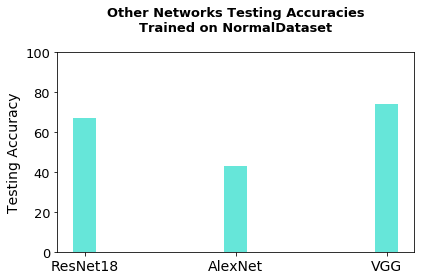

In [47]:
n_groups = 3

accuracies = (67, 43, 74)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
font_size_large = 14
font_size_small = 13

rects1 = plt.bar(index + bar_width, accuracies, bar_width,
alpha=opacity,
color='turquoise')

plt.ylim(0,100)
plt.ylabel('Testing Accuracy', fontsize=font_size_large)
plt.title('Other Networks Testing Accuracies\nTrained on NormalDataset\n', fontweight='bold', fontsize=font_size_small)
plt.xticks(index + bar_width, ('ResNet18', 'AlexNet', 'VGG'), fontsize=font_size_large)
plt.yticks(fontsize=font_size_small)


plt.tight_layout()
plt.show()

ResNet18 training time: 5451 seconds
AlexNet training time: 5159 seconds
VGG training time: 15253 seconds


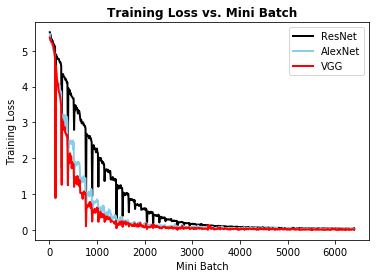

In [48]:
res_time_other = 5451
alex_time = 5159
vgg_time = 15253

print("ResNet18 training time:", res_time_other, "seconds")
print("AlexNet training time:", alex_time, "seconds")
print("VGG training time:", vgg_time, "seconds")

other_nets_x = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379, 389, 399, 409, 419, 429, 439, 449, 459, 469, 479, 489, 499, 509, 519, 529, 539, 549, 559, 569, 579, 589, 599, 609, 619, 629, 639, 649, 659, 669, 679, 689, 699, 709, 719, 729, 739, 749, 759, 769, 779, 789, 799, 809, 819, 829, 839, 849, 859, 869, 879, 889, 899, 909, 919, 929, 939, 949, 959, 969, 979, 989, 999, 1009, 1019, 1029, 1039, 1049, 1059, 1069, 1079, 1089, 1099, 1109, 1119, 1129, 1139, 1149, 1159, 1169, 1179, 1189, 1199, 1209, 1219, 1229, 1239, 1249, 1259, 1269, 1279, 1289, 1299, 1309, 1319, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1399, 1409, 1419, 1429, 1439, 1449, 1459, 1469, 1479, 1489, 1499, 1509, 1519, 1529, 1539, 1549, 1559, 1569, 1579, 1589, 1599, 1609, 1619, 1629, 1639, 1649, 1659, 1669, 1679, 1689, 1699, 1709, 1719, 1729, 1739, 1749, 1759, 1769, 1779, 1789, 1799, 1809, 1819, 1829, 1839, 1849, 1859, 1869, 1879, 1889, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2029, 2039, 2049, 2059, 2069, 2079, 2089, 2099, 2109, 2119, 2129, 2139, 2149, 2159, 2169, 2179, 2189, 2199, 2209, 2219, 2229, 2239, 2249, 2259, 2269, 2279, 2289, 2299, 2309, 2319, 2329, 2339, 2349, 2359, 2369, 2379, 2389, 2399, 2409, 2419, 2429, 2439, 2449, 2459, 2469, 2479, 2489, 2499, 2509, 2519, 2529, 2539, 2549, 2559, 2569, 2579, 2589, 2599, 2609, 2619, 2629, 2639, 2649, 2659, 2669, 2679, 2689, 2699, 2709, 2719, 2729, 2739, 2749, 2759, 2769, 2779, 2789, 2799, 2809, 2819, 2829, 2839, 2849, 2859, 2869, 2879, 2889, 2899, 2909, 2919, 2929, 2939, 2949, 2959, 2969, 2979, 2989, 2999, 3009, 3019, 3029, 3039, 3049, 3059, 3069, 3079, 3089, 3099, 3109, 3119, 3129, 3139, 3149, 3159, 3169, 3179, 3189, 3199, 3209, 3219, 3229, 3239, 3249, 3259, 3269, 3279, 3289, 3299, 3309, 3319, 3329, 3339, 3349, 3359, 3369, 3379, 3389, 3399, 3409, 3419, 3429, 3439, 3449, 3459, 3469, 3479, 3489, 3499, 3509, 3519, 3529, 3539, 3549, 3559, 3569, 3579, 3589, 3599, 3609, 3619, 3629, 3639, 3649, 3659, 3669, 3679, 3689, 3699, 3709, 3719, 3729, 3739, 3749, 3759, 3769, 3779, 3789, 3799, 3809, 3819, 3829, 3839, 3849, 3859, 3869, 3879, 3889, 3899, 3909, 3919, 3929, 3939, 3949, 3959, 3969, 3979, 3989, 3999, 4009, 4019, 4029, 4039, 4049, 4059, 4069, 4079, 4089, 4099, 4109, 4119, 4129, 4139, 4149, 4159, 4169, 4179, 4189, 4199, 4209, 4219, 4229, 4239, 4249, 4259, 4269, 4279, 4289, 4299, 4309, 4319, 4329, 4339, 4349, 4359, 4369, 4379, 4389, 4399, 4409, 4419, 4429, 4439, 4449, 4459, 4469, 4479, 4489, 4499, 4509, 4519, 4529, 4539, 4549, 4559, 4569, 4579, 4589, 4599, 4609, 4619, 4629, 4639, 4649, 4659, 4669, 4679, 4689, 4699, 4709, 4719, 4729, 4739, 4749, 4759, 4769, 4779, 4789, 4799, 4809, 4819, 4829, 4839, 4849, 4859, 4869, 4879, 4889, 4899, 4909, 4919, 4929, 4939, 4949, 4959, 4969, 4979, 4989, 4999, 5009, 5019, 5029, 5039, 5049, 5059, 5069, 5079, 5089, 5099, 5109, 5119, 5129, 5139, 5149, 5159, 5169, 5179, 5189, 5199, 5209, 5219, 5229, 5239, 5249, 5259, 5269, 5279, 5289, 5299, 5309, 5319, 5329, 5339, 5349, 5359, 5369, 5379, 5389, 5399, 5409, 5419, 5429, 5439, 5449, 5459, 5469, 5479, 5489, 5499, 5509, 5519, 5529, 5539, 5549, 5559, 5569, 5579, 5589, 5599, 5609, 5619, 5629, 5639, 5649, 5659, 5669, 5679, 5689, 5699, 5709, 5719, 5729, 5739, 5749, 5759, 5769, 5779, 5789, 5799, 5809, 5819, 5829, 5839, 5849, 5859, 5869, 5879, 5889, 5899, 5909, 5919, 5929, 5939, 5949, 5959, 5969, 5979, 5989, 5999, 6009, 6019, 6029, 6039, 6049, 6059, 6069, 6079, 6089, 6099, 6109, 6119, 6129, 6139, 6149, 6159, 6169, 6179, 6189, 6199, 6209, 6219, 6229, 6239, 6249, 6259, 6269, 6279, 6289, 6299, 6309, 6319, 6329, 6339, 6349, 6359, 6369, 6379, 6389, 6399]
normal_y_other = [5.518881940841675, 5.471435546875, 5.421441078186035, 5.3115355491638185, 5.323732233047485, 5.278787994384766, 5.2776686668396, 5.219737768173218, 5.1703578472137455, 5.171693992614746, 5.141298818588257, 5.11266860961914, 0.985878849029541, 4.900802898406982, 4.862150573730469, 4.837510824203491, 4.799245166778564, 4.773163747787476, 4.771245050430298, 4.773955535888672, 4.721166896820068, 4.677434921264648, 4.687036657333374, 4.65318660736084, 4.569459581375122, 1.7429664134979248, 4.349269199371338, 4.3344193458557125, 4.345509147644043, 4.294446134567261, 4.272018241882324, 4.2602170467376705, 4.231729745864868, 4.1838582992553714, 4.208635544776916, 4.154182291030883, 4.1042297124862674, 4.121517372131348, 2.353252649307251, 3.955579972267151, 3.8812193393707277, 3.8085727453231812, 3.9019980430603027, 3.7874959468841554, 3.8181512117385865, 3.754002022743225, 3.73443398475647, 3.714916968345642, 3.6851473331451414, 3.6725853443145753, 3.6704631090164184, 2.7931724786758423, 3.4765952587127686, 3.33768253326416, 3.479300093650818, 3.4075019359588623, 3.389440679550171, 3.4138649463653565, 3.3343436241149904, 3.2504462003707886, 3.3465370893478394, 3.2926685094833372, 3.310813283920288, 3.2179543733596803, 3.0884014129638673, 3.03773832321167, 3.077271056175232, 2.9744767427444456, 2.976794981956482, 3.00150887966156, 3.003497672080994, 2.9294344663619993, 2.93962938785553, 2.8952773094177244, 2.8966612815856934, 2.835630178451538, 0.5684725046157837, 2.685181212425232, 2.6628403186798097, 2.6386602401733397, 2.6318191289901733, 2.6326387405395506, 2.5838455677032472, 2.5532982110977174, 2.625342845916748, 2.5721390008926392, 2.5656320571899416, 2.5023125648498534, 2.4415042638778686, 0.9502989530563355, 2.28592164516449, 2.2674911499023436, 2.3680468559265138, 2.257646083831787, 2.2659475564956666, 2.284512186050415, 2.2366764545440674, 2.166995108127594, 2.183494520187378, 2.27211651802063, 2.1724364519119264, 2.1436248779296876, 1.2086657285690308, 2.019158720970154, 1.9869184374809266, 1.9919013857841492, 1.9641290545463561, 2.0104801058769226, 1.926613175868988, 1.9347389101982118, 1.8613313555717468, 1.8882944226264953, 1.89907968044281, 1.8309538960456848, 1.8324818730354309, 1.365023910999298, 1.6277134895324707, 1.6806878089904784, 1.6887227773666382, 1.674371862411499, 1.6878240704536438, 1.6363955020904541, 1.6819998025894165, 1.6133264541625976, 1.650690221786499, 1.606079876422882, 1.6522234082221985, 1.6432724118232727, 1.4092804670333863, 1.4501837134361266, 1.429482889175415, 1.4034082770347596, 1.4756528854370117, 1.4618811011314392, 1.3983100771903991, 1.3934866428375243, 1.3809876203536988, 1.423111128807068, 1.3871965289115906, 1.4086787462234498, 0.24777218103408813, 1.1901450157165527, 1.2554213523864746, 1.1512536883354187, 1.1794938921928406, 1.160666835308075, 1.2372575163841248, 1.1693023800849915, 1.1986181497573853, 1.249567973613739, 1.1743127822875976, 1.166147565841675, 1.169013547897339, 0.39333389401435853, 0.9945794820785523, 1.0416393458843232, 1.0270845949649812, 0.993798679113388, 0.9679964721202851, 0.9797811150550843, 1.028968095779419, 1.0069933831691742, 1.000820231437683, 1.030192142724991, 0.9858311593532563, 1.0043345272541047, 0.4958032250404358, 0.8587393343448639, 0.8591744780540467, 0.8693193554878235, 0.8379893600940704, 0.8373633801937104, 0.857178556919098, 0.8571664810180664, 0.8318487465381622, 0.816985684633255, 0.8313745319843292, 0.7828503608703613, 0.8327103137969971, 0.5853817105293274, 0.696182805299759, 0.7079394459724426, 0.6992075204849243, 0.6989964783191681, 0.7232424974441528, 0.7024275004863739, 0.6852933168411255, 0.6744904518127441, 0.6726997911930084, 0.6866573393344879, 0.7100703060626984, 0.7257169246673584, 0.565558671951294, 0.5638088703155517, 0.5845650166273118, 0.5944619536399841, 0.5853651344776154, 0.5784417748451233, 0.606739592552185, 0.593934953212738, 0.5640969812870026, 0.603768402338028, 0.5833215713500977, 0.5766135573387146, 0.09877384901046753, 0.5079230904579163, 0.48342320919036863, 0.5144264042377472, 0.48116785287857056, 0.45464294850826265, 0.5002337545156479, 0.4733849197626114, 0.5105759799480438, 0.47464931905269625, 0.48777791261672976, 0.47878832519054415, 0.4944511741399765, 0.1796547681093216, 0.39702423214912413, 0.42666162848472594, 0.41544708907604216, 0.4176731795072556, 0.4100668281316757, 0.3957776665687561, 0.4078033596277237, 0.3935050070285797, 0.3867966651916504, 0.39575675427913665, 0.42955462634563446, 0.41221890449523924, 0.2086825340986252, 0.342960125207901, 0.340789732336998, 0.3699441432952881, 0.33240375518798826, 0.3205039143562317, 0.3521841526031494, 0.34606524705886843, 0.3480427175760269, 0.32795813083648684, 0.33347865343093874, 0.35002716481685636, 0.32785153985023496, 0.24307381510734558, 0.3107619255781174, 0.2960875198245049, 0.2919465973973274, 0.2891583859920502, 0.29700401723384856, 0.30088338553905486, 0.2904084146022797, 0.2894234284758568, 0.28543544709682467, 0.2923704296350479, 0.3067538529634476, 0.30590231716632843, 0.24395262002944945, 0.25421358197927474, 0.2466900035738945, 0.2563319608569145, 0.2446942836046219, 0.2651467353105545, 0.2497896671295166, 0.25248451828956603, 0.24966794699430467, 0.24995502978563308, 0.25530926138162613, 0.24999988228082656, 0.04148611724376679, 0.22348911166191102, 0.21274326890707015, 0.20777678936719896, 0.2167075350880623, 0.21355533003807067, 0.21636687219142914, 0.21904794573783876, 0.22085664421319962, 0.22297214567661286, 0.2264154702425003, 0.215047886967659, 0.20594292134046555, 0.07429599463939666, 0.19077995270490647, 0.1978919193148613, 0.18271566033363343, 0.19062237441539764, 0.18852075487375258, 0.1914428561925888, 0.18829085528850556, 0.19079746156930924, 0.1910938575863838, 0.18887805491685866, 0.17843603938817978, 0.19151709377765655, 0.09858924150466919, 0.16951365917921066, 0.1663925752043724, 0.16892355531454087, 0.16693794578313828, 0.171598482131958, 0.1697363391518593, 0.17350600957870482, 0.16181685477495195, 0.16353861391544341, 0.1675422117114067, 0.16787754744291306, 0.16133038848638534, 0.1262279510498047, 0.1416003242135048, 0.15009919181466103, 0.1453053206205368, 0.15040527135133744, 0.14792079776525496, 0.15026412904262543, 0.14910576045513152, 0.14841634184122085, 0.1442950740456581, 0.16023822277784347, 0.1452167436480522, 0.16365168541669844, 0.13099246695637703, 0.13465183079242707, 0.13858173713088034, 0.13142354860901834, 0.14130476042628287, 0.13827072381973265, 0.12822895720601082, 0.13566723614931106, 0.13373330980539322, 0.13303781002759935, 0.1334191158413887, 0.1374865174293518, 0.02472996711730957, 0.12320817857980729, 0.11955768838524819, 0.1194416768848896, 0.11797309145331383, 0.1259993851184845, 0.12095486894249916, 0.12543935775756837, 0.1261361174285412, 0.11752122044563293, 0.11825087368488311, 0.12229050174355507, 0.11616499051451683, 0.04181278645992279, 0.11170855984091758, 0.1101689875125885, 0.10960714966058731, 0.10700771063566208, 0.11030726358294488, 0.1092419371008873, 0.10710992962121964, 0.11665831431746483, 0.11532538682222367, 0.10835409760475159, 0.10367686673998833, 0.10740478038787842, 0.05997494906187058, 0.09835033044219017, 0.10129568576812745, 0.10337549522519111, 0.0990679644048214, 0.1059903308749199, 0.10193950459361076, 0.1032947339117527, 0.09787053912878037, 0.0949039876461029, 0.10526035651564598, 0.09974870607256889, 0.09979108795523643, 0.07555796280503273, 0.09024753347039223, 0.09079509004950523, 0.09059519097208976, 0.09140380024909973, 0.09193826392292977, 0.09762114956974983, 0.0947223149240017, 0.09319313168525696, 0.0952904500067234, 0.09480880498886109, 0.08633921593427658, 0.09494296610355377, 0.0854385145008564, 0.08297183588147164, 0.08172998651862144, 0.08892773985862731, 0.08503137156367302, 0.08905668407678605, 0.09151470363140106, 0.08616646975278855, 0.08823489993810654, 0.08090013414621353, 0.09231813326478004, 0.08489774465560913, 0.01604076325893402, 0.08350545465946198, 0.07852995842695236, 0.08035932406783104, 0.07841552570462226, 0.08105055317282676, 0.07932787910103797, 0.07994322329759598, 0.07648166492581368, 0.08520508632063865, 0.07891595140099525, 0.08783571049571037, 0.07942072451114654, 0.02770507484674454, 0.07074189484119416, 0.07382392138242722, 0.07637266367673874, 0.07445422485470772, 0.07306957542896271, 0.076454558968544, 0.07807584702968598, 0.07222234159708023, 0.08421268537640572, 0.07322354167699814, 0.07368582710623742, 0.07739120200276375, 0.03910993710160256, 0.06380106955766678, 0.07544832825660705, 0.06934877783060074, 0.06355169340968132, 0.06867409944534301, 0.06792727038264275, 0.06919064223766327, 0.07351315021514893, 0.07076702862977982, 0.07104325369000435, 0.06833737045526504, 0.06869209483265877, 0.05267981886863708, 0.06401342451572418, 0.07198886796832085, 0.06850789040327072, 0.06627368107438088, 0.06434648409485817, 0.06314439624547959, 0.06178793385624885, 0.06516132950782776, 0.06432939320802689, 0.06349781453609467, 0.06694661229848861, 0.07658849656581879, 0.06199013069272041, 0.06463479697704315, 0.05817646011710167, 0.057839500904083255, 0.05825835466384888, 0.06120166629552841, 0.059679196774959566, 0.06151516810059547, 0.06566834896802902, 0.06271833181381226, 0.06259964257478715, 0.07052305638790131, 0.011715935915708542, 0.05681782215833664, 0.06040328443050384, 0.05803547352552414, 0.057532291114330295, 0.06152360886335373, 0.059798549860715866, 0.0606838196516037, 0.05746631771326065, 0.06207857578992844, 0.05971278101205826, 0.05905351787805557, 0.05949740633368492, 0.02196691185235977, 0.05664188116788864, 0.056543315201997756, 0.0549267366528511, 0.05511387288570404, 0.057695959508419034, 0.05650099068880081, 0.06084317564964294, 0.05606383979320526, 0.054046301543712615, 0.05298609584569931, 0.05319041907787323, 0.057476569712162015, 0.030795535445213316, 0.050055141746997836, 0.052783678472042087, 0.06095818281173706, 0.05411743298172951, 0.05566718727350235, 0.050063511729240416, 0.05515381097793579, 0.04919300079345703, 0.050894930958747864, 0.05086043030023575, 0.05071652382612228, 0.0540038987994194, 0.04247749596834183, 0.049699117243289945, 0.05250854641199112, 0.04712970107793808, 0.05066170990467071, 0.04494099467992783, 0.059584418684244154, 0.050149907171726224, 0.04819644540548325, 0.04798086285591126, 0.05015389546751976, 0.049670130014419556, 0.0636903241276741, 0.0518464520573616, 0.05161478221416473, 0.04614310711622238, 0.04579986780881882, 0.04426024556159973, 0.05203425884246826, 0.045996743440628055, 0.04969598352909088, 0.04449907243251801, 0.04931209981441498, 0.04967761486768722, 0.04783246368169784, 0.00899883806705475, 0.046685443818569185, 0.04326992779970169, 0.04519261717796326, 0.04521468728780746, 0.04564429372549057, 0.05244583487510681, 0.046327313780784606, 0.04785789102315903, 0.043706899881362914, 0.042877666652202606, 0.05144806727766991, 0.04390446543693542, 0.019821406900882722, 0.04227408468723297, 0.04480384737253189, 0.04471251517534256, 0.046193838119506836, 0.04346224218606949, 0.04637095183134079, 0.046963156759738924, 0.042591202259063723, 0.040896874666213986, 0.043064388632774356, 0.04021658599376678, 0.04207799434661865, 0.02547033056616783, 0.03973497748374939, 0.04220763891935349, 0.03988002836704254, 0.04465692192316055, 0.042697121202945706, 0.03906475901603699, 0.041252581775188445, 0.04150127917528153, 0.04037114679813385, 0.04056993424892426, 0.03923709094524384, 0.04250727444887161, 0.03262038677930832, 0.04276723563671112, 0.04316052198410034, 0.04484463483095169, 0.03806504905223847, 0.03740212023258209, 0.03829113394021988, 0.03682393878698349, 0.04411384612321854, 0.041795593500137326, 0.04181232154369354, 0.04514458775520325, 0.046541304886341096, 0.044352291524410246, 0.039255908131599425, 0.03813692182302475, 0.038103929907083514, 0.03568042665719986, 0.04094232469797134, 0.03889632821083069, 0.036615557968616486, 0.03677140772342682, 0.041111508011817934, 0.039858675003051756, 0.03770725131034851, 0.00988980382680893, 0.03663540333509445, 0.03660195767879486, 0.038360193371772766, 0.040707807242870334, 0.03793565481901169, 0.03520834296941757, 0.036653940379619596, 0.036810027062892915, 0.036684392392635344, 0.03454021364450455, 0.0410981148481369, 0.044626906514167786, 0.013010334968566895, 0.035680414736270906, 0.0367182731628418, 0.0343519926071167, 0.03486720770597458, 0.03732744157314301, 0.03534735143184662, 0.03942724913358688, 0.039249290525913236, 0.03428205400705338, 0.03350846022367478, 0.036805035173892976, 0.03964075595140457, 0.018785880506038667, 0.03135216385126114, 0.03588872253894806, 0.03444348573684693, 0.03240584284067154, 0.0318528413772583, 0.03448418378829956, 0.04072502255439758, 0.03095909208059311, 0.03421763926744461, 0.03789149820804596, 0.034659041464328764, 0.03887177407741547, 0.027242836356163026, 0.03339644074440003, 0.02907402366399765, 0.03377936631441116, 0.03187213540077209, 0.029783067107200623, 0.03299450278282166, 0.03451360762119293, 0.03354361355304718, 0.03127896934747696, 0.03868797868490219, 0.03597142547369003, 0.0446257621049881]
alex_net_y = [5.466919565200806, 5.341326475143433, 5.289546251296997, 5.2428741455078125, 5.190214443206787, 5.156225395202637, 5.165346670150757, 5.015604257583618, 5.010516500473022, 4.966745471954345, 4.919031381607056, 4.7923948764801025, 0.8749088764190673, 4.4083781242370605, 4.243473386764526, 4.21069188117981, 4.179302930831909, 4.11100161075592, 4.141635513305664, 4.019375371932983, 4.046210479736328, 3.997625303268433, 3.8277053594589234, 3.8753955602645873, 3.8286539554595946, 1.3567564249038697, 3.218520927429199, 3.139954924583435, 3.1101115942001343, 3.2287376165390014, 3.031612014770508, 2.8815709829330443, 3.120627284049988, 3.1923349857330323, 3.1331891298294066, 3.1282975912094115, 3.159830188751221, 3.016032409667969, 1.3913525104522706, 2.404264521598816, 2.307685375213623, 2.4825526237487794, 2.460275101661682, 2.481147837638855, 2.496677207946777, 2.398849868774414, 2.454313349723816, 2.442217969894409, 2.498606562614441, 2.2548178672790526, 2.4567872285842896, 1.44181832075119, 1.686142337322235, 1.8025466084480286, 1.8943917393684386, 1.8070449829101562, 1.8187434196472168, 1.8191296577453613, 1.8616849660873414, 1.9038211464881898, 1.8505098342895507, 1.892485463619232, 1.864996361732483, 1.7413485884666442, 1.2816126704216004, 1.349280548095703, 1.4615041971206666, 1.3787746906280518, 1.3322931289672852, 1.3317741751670837, 1.3465823888778687, 1.5035822987556458, 1.4344290733337401, 1.3690557658672333, 1.4491356492042542, 1.4452171444892883, 0.16293847560882568, 1.0186382949352264, 0.9598682463169098, 1.0169335007667542, 1.032257354259491, 1.009241336584091, 1.0681788206100464, 0.9370861649513245, 1.0322100162506103, 1.0294140934944154, 1.0709363043308258, 1.1468579292297363, 1.104835194349289, 0.27221882343292236, 0.6965083062648774, 0.6823674529790879, 0.8037703990936279, 0.7370619058609009, 0.7805293321609497, 0.7684237241744996, 0.7663925051689148, 0.8069264769554139, 0.795831948518753, 0.8547879576683044, 0.8207585394382477, 0.8158886909484864, 0.2963939607143402, 0.5389026999473572, 0.5059785276651383, 0.6231604516506195, 0.6332961916923523, 0.5801841825246811, 0.5303990483283997, 0.5461273103952408, 0.535834726691246, 0.683142414689064, 0.6432707726955413, 0.5547770529985427, 0.6541374623775482, 0.3104106396436691, 0.3903303474187851, 0.39473083019256594, 0.46839074194431307, 0.4373266249895096, 0.4993940591812134, 0.46312476694583893, 0.3888422608375549, 0.4914412349462509, 0.5762077391147613, 0.4745979130268097, 0.5273801058530807, 0.5342258602380753, 0.35682994723320005, 0.430124306678772, 0.2886100858449936, 0.28715981990098954, 0.32880845069885256, 0.3527010053396225, 0.34711540043354033, 0.331886488199234, 0.4197036862373352, 0.41028240621089934, 0.3949596703052521, 0.3843229115009308, 0.06984425783157348, 0.2969668909907341, 0.28454387187957764, 0.2688869655132294, 0.2626064091920853, 0.2578773573040962, 0.26504795253276825, 0.2681542903184891, 0.3600041657686234, 0.32485022246837614, 0.3455947518348694, 0.2922943413257599, 0.35136340707540514, 0.08360924869775772, 0.2693492963910103, 0.2778376966714859, 0.2522789388895035, 0.22787453681230546, 0.22871207743883132, 0.20110365450382234, 0.27143990248441696, 0.17626428753137588, 0.2200368270277977, 0.22196106761693954, 0.2714746087789536, 0.24004050642251967, 0.1135460764169693, 0.18545996099710466, 0.1734781503677368, 0.1717613860964775, 0.177787709236145, 0.19054136276245118, 0.12011651992797852, 0.19235908091068268, 0.14699635654687881, 0.2023824095726013, 0.1598014384508133, 0.22239575386047364, 0.23272880017757416, 0.12468952238559723, 0.17205726504325866, 0.13720599859952926, 0.1439119353890419, 0.1771793022751808, 0.16719242036342621, 0.12969765812158585, 0.21268308013677598, 0.12873933911323548, 0.16534020900726318, 0.20462171286344527, 0.21888800263404845, 0.14135511368513107, 0.1385497495532036, 0.11824637800455093, 0.12741475254297258, 0.11966287344694138, 0.12271652072668075, 0.16200263500213624, 0.15559062212705613, 0.1930468961596489, 0.18281590342521667, 0.16565293818712234, 0.14955337941646576, 0.1900951474905014, 0.02116995453834534, 0.14469704031944275, 0.1272247239947319, 0.11088618338108062, 0.12073441296815872, 0.14485953152179717, 0.12466798573732377, 0.13319142609834672, 0.09381837695837021, 0.1568790301680565, 0.13294984251260758, 0.13217465430498124, 0.14554939568042755, 0.04350188821554184, 0.1433858796954155, 0.12446016818284988, 0.11103785037994385, 0.10422057509422303, 0.09108194708824158, 0.1089200422167778, 0.11472470164299012, 0.13362077325582505, 0.13218982964754106, 0.11067878007888794, 0.12022345215082168, 0.12975429892539977, 0.04365287944674492, 0.09991064071655273, 0.08477870374917984, 0.13590089976787567, 0.10349083393812179, 0.09217414110898972, 0.09557703733444214, 0.12206255495548249, 0.12291217744350433, 0.08152656704187393, 0.12406127154827118, 0.13141487240791322, 0.13119602650403978, 0.05496525764465332, 0.08549693375825881, 0.07592447847127914, 0.08026292324066162, 0.07700487226247787, 0.0965458869934082, 0.09603795856237411, 0.0961815819144249, 0.07606517970561981, 0.10145214349031448, 0.09911142662167549, 0.09364086389541626, 0.12218472063541412, 0.06372329145669937, 0.08809456378221511, 0.10605058073997498, 0.08686431795358658, 0.10602808892726898, 0.08517449051141739, 0.11325944513082505, 0.1709843248128891, 0.08192837238311768, 0.0880395844578743, 0.10387390255928039, 0.08328155577182769, 0.00872277319431305, 0.10039332062005997, 0.07854920476675034, 0.061309291422367095, 0.05099579989910126, 0.07327735126018524, 0.09587773978710175, 0.067444708943367, 0.0904070258140564, 0.06753367185592651, 0.15906934291124344, 0.08305036723613739, 0.07544340640306473, 0.025948597490787505, 0.09804583489894866, 0.10013445615768432, 0.07235762625932693, 0.09113458544015884, 0.05307458490133286, 0.06550937592983246, 0.06692778468132018, 0.06609387770295143, 0.055723659694194794, 0.05745483636856079, 0.05826569497585297, 0.07395984828472138, 0.06977881342172623, 0.07317930012941361, 0.08927593976259232, 0.04660515189170837, 0.08104178160429001, 0.0651110827922821, 0.04858567714691162, 0.10176454782485962, 0.10912538021802902, 0.07431147694587707, 0.0880116805434227, 0.06953005492687225, 0.10763468891382218, 0.037675656378269196, 0.04434199631214142, 0.028273677825927733, 0.04456254094839096, 0.12123762220144271, 0.08723546266555786, 0.08302296549081803, 0.06754935085773468, 0.05963142365217209, 0.0684245690703392, 0.06907767057418823, 0.09460485726594925, 0.06366292089223861, 0.07383837550878525, 0.04422042369842529, 0.036018106341362, 0.045438040792942044, 0.03740142285823822, 0.04765693247318268, 0.0401069238781929, 0.06782628446817399, 0.05836498737335205, 0.07680769115686417, 0.08247377425432205, 0.10389779806137085, 0.012458273768424987, 0.08733957409858703, 0.06586258411407471, 0.06693236976861953, 0.04641188830137253, 0.05906714051961899, 0.04605248868465424, 0.032412904500961306, 0.06997866630554199, 0.05373056679964065, 0.08539143651723861, 0.06776955127716064, 0.05953722670674324, 0.025198109447956085, 0.033416633307933805, 0.048160091042518616, 0.03600013554096222, 0.046747630834579466, 0.06838682442903518, 0.0433899849653244, 0.040761415660381314, 0.040395723283290864, 0.07551399022340774, 0.06130283772945404, 0.06853077262639999, 0.07985342293977737, 0.04232420027256012, 0.05123109221458435, 0.04881935268640518, 0.08150292187929153, 0.059319335222244265, 0.08853352218866348, 0.04958582222461701, 0.046140937507152556, 0.03627675324678421, 0.038899187743663785, 0.04578022807836533, 0.04549240916967392, 0.056646183133125305, 0.032497231662273404, 0.03697118759155273, 0.05479614287614822, 0.03573389947414398, 0.05558355450630188, 0.05305728167295456, 0.05854160189628601, 0.060424831509590146, 0.04919183999300003, 0.05721682012081146, 0.03188962936401367, 0.033603130280971526, 0.05895691365003586, 0.032652963697910306, 0.04104080349206925, 0.04677820652723312, 0.04926638007164001, 0.06315910518169403, 0.034439007937908175, 0.05031299889087677, 0.04753480106592178, 0.04029481112957001, 0.049149543046951294, 0.04563173204660416, 0.04373878538608551, 0.004681597650051117, 0.055065985023975375, 0.020662075281143187, 0.04014780223369598, 0.02879323661327362, 0.03966474086046219, 0.0523602768778801, 0.04631875306367874, 0.04527187198400497, 0.030629314482212067, 0.047623267769813536, 0.05060809999704361, 0.07980133146047592, 0.0102621391415596, 0.040867733955383304, 0.044323645532131195, 0.04292543828487396, 0.0464516207575798, 0.025026509165763856, 0.05250995606184006, 0.03795950263738632, 0.047563803195953366, 0.04012804925441742, 0.04036283195018768, 0.03737854361534119, 0.08785311728715897, 0.021647219359874726, 0.0383918970823288, 0.0464387372136116, 0.04511968195438385, 0.029023490846157074, 0.039951561391353606, 0.022271716594696046, 0.042276817560195926, 0.05899738818407059, 0.03784366846084595, 0.07127545177936553, 0.03930580168962479, 0.029995501041412354, 0.022144678235054015, 0.01649954915046692, 0.014680024981498719, 0.045734500885009764, 0.04526526629924774, 0.032779502868652347, 0.01657404750585556, 0.038761763274669646, 0.02160225510597229, 0.04122817069292069, 0.044583164155483246, 0.03311367481946945, 0.04600889980792999, 0.04398796558380127, 0.024033325910568237, 0.03348568230867386, 0.0236797034740448, 0.01910829097032547, 0.046953926980495456, 0.029815076291561125, 0.02775121182203293, 0.045548371970653534, 0.045404520630836484, 0.04569367319345474, 0.021926845610141753, 0.0014906927943229675, 0.038367035984992984, 0.04105792492628098, 0.037302848696708676, 0.025765636563301088, 0.05090596377849579, 0.02715706080198288, 0.0341022789478302, 0.032375463843345643, 0.02556633800268173, 0.04019845277070999, 0.030144713819026947, 0.054146042466163634, 0.01466723382472992, 0.026938705146312712, 0.045884010195732114, 0.019364944100379942, 0.05859903246164322, 0.027623957395553587, 0.03178553134202957, 0.02515409141778946, 0.01809893101453781, 0.022336746752262115, 0.01801745742559433, 0.03236774057149887, 0.02549310326576233, 0.02902577668428421, 0.02938402146100998, 0.02638106644153595, 0.015891042351722718, 0.05555851012468338, 0.03017182946205139, 0.033034950494766235, 0.025713156163692474, 0.03437939882278442, 0.031602895259857176, 0.03947342932224274, 0.04990359097719192, 0.06438060849905014, 0.023070172965526582, 0.05465727150440216, 0.048377297818660736, 0.04579743817448616, 0.048209448158740995, 0.031532424688339236, 0.05227779597043991, 0.041959986090660095, 0.045432187616825104, 0.021889951825141907, 0.03179694563150406, 0.025487178564071657, 0.03530016839504242, 0.024274729192256927, 0.02245350331068039, 0.025980657339096068, 0.040640832483768465, 0.05537848323583603, 0.025381967425346375, 0.014533448219299316, 0.035405895113945006, 0.038138453662395475, 0.040160815417766574, 0.01958497762680054, 0.03363835513591766, 0.0024420976638793944, 0.032869425415992734, 0.025455945730209352, 0.010328127443790436, 0.008838853240013123, 0.01492658406496048, 0.03154224008321762, 0.02852901667356491, 0.040295261144638064, 0.03682508319616318, 0.025350768864154816, 0.04677416980266571, 0.022209526598453523, 0.005671757459640503, 0.018986693024635314, 0.02010570913553238, 0.04430781304836273, 0.023916569352149964, 0.03689510673284531, 0.0250749409198761, 0.018173669278621674, 0.036111457645893096, 0.013836546242237091, 0.013672374188899994, 0.038646720349788666, 0.025888170301914214, 0.008737422525882721, 0.036039695143699646, 0.02719833105802536, 0.0304663747549057, 0.017894564568996428, 0.031136372685432435, 0.028266730904579162, 0.040203677117824556, 0.04564796090126037, 0.018254844844341277, 0.04257685542106628, 0.04275052547454834, 0.017768070101737976, 0.028205473721027375, 0.02530689537525177, 0.03421891331672668, 0.014988812804222106, 0.027158071100711823, 0.045908364653587344, 0.01921439468860626, 0.029537861049175263, 0.023010537028312683, 0.022085607051849365, 0.022816160321235658, 0.041074956953525546, 0.014840060472488403, 0.014401552081108094, 0.017157630622386934, 0.025901691615581514, 0.01968788057565689, 0.036215277016162874, 0.010238629579544068, 0.018977537751197815, 0.01541014462709427, 0.016664369404315947, 0.026975831389427184, 0.017346674203872682, 0.03597205579280853, 0.001122996211051941, 0.01500912308692932, 0.022337284684181214, 0.016469040513038637, 0.019013772904872894, 0.03144313097000122, 0.03823530524969101, 0.013851107656955719, 0.040542694926261905, 0.017597630620002747, 0.04062725752592087, 0.017961330711841583, 0.01065341979265213, 0.01091289073228836, 0.015210437774658202, 0.01570212095975876, 0.028037191927433015, 0.0173758864402771, 0.03156932592391968, 0.021112480759620668, 0.027257284522056578, 0.021985232830047607, 0.04136196225881576, 0.02911487966775894, 0.037287309765815735, 0.022647342085838316, 0.005025547742843628, 0.012134876847267152, 0.012449949979782104, 0.010511358082294465, 0.037380488216876985, 0.014166910946369172, 0.04357854574918747, 0.020234325528144838, 0.03496857285499573, 0.016686612367630006, 0.018654873967170714, 0.0383602499961853, 0.029119664430618288, 0.022839753329753874, 0.01646607369184494, 0.015388256311416626, 0.022963930666446686, 0.0228241503238678, 0.0158165842294693, 0.02514023184776306, 0.019243809580802917, 0.01697757691144943, 0.018798565864562987, 0.029916660487651826, 0.024010121822357178, 0.014045566320419312]
vgg_y = [5.370085096359253, 5.303014802932739, 5.283579397201538, 5.253327035903931, 5.242403650283814, 5.223728466033935, 5.188111400604248, 5.160761547088623, 5.078415870666504, 5.028976821899414, 4.9079986095428465, 4.8053398609161375, 0.8978078365325928, 4.586529636383057, 4.40276198387146, 4.230863571166992, 4.031761598587036, 4.077763843536377, 3.9326992273330688, 3.8490592002868653, 3.8271852254867555, 3.7516605854034424, 3.6908764839172363, 3.5607704639434816, 3.4412834644317627, 1.2598015785217285, 3.0846768379211427, 2.9321946620941164, 3.016041946411133, 2.8268283128738405, 2.7883843898773195, 2.876703667640686, 2.737723469734192, 2.700241231918335, 2.6911954402923586, 2.625816750526428, 2.6065640687942504, 2.6473166942596436, 1.2490788102149963, 2.0292869806289673, 2.049236476421356, 1.860352671146393, 2.1417272090911865, 2.1063915848731996, 1.9828954935073853, 2.048083996772766, 1.7214670300483703, 1.8930577635765076, 1.7976595997810363, 1.8263290882110597, 1.8313247799873351, 1.2027075052261353, 1.4847047209739686, 1.3102638125419617, 1.460935604572296, 1.3424088954925537, 1.3838242411613464, 1.277395737171173, 1.508319342136383, 1.4105546355247498, 1.3502901554107667, 1.229812639951706, 1.4013745069503785, 1.3527527689933776, 1.0293821930885314, 1.0333621084690094, 1.0268289387226104, 1.0353423714637757, 0.9619205117225647, 0.8695175290107727, 1.0499867498874664, 1.0598420560359956, 1.0784767866134644, 1.0012655138969422, 1.0178589046001434, 1.0312342941761017, 0.10209867060184478, 0.675267681479454, 0.672299274802208, 0.632885017991066, 0.6976947009563446, 0.7148519515991211, 0.6613722383975983, 0.7643895328044892, 0.7545861065387726, 0.7819231688976288, 0.615086418390274, 0.720430713891983, 0.5982199370861053, 0.23500269055366516, 0.5439596563577652, 0.5209493815898896, 0.5127534180879593, 0.48441448211669924, 0.5908615738153458, 0.5528113216161727, 0.48017502427101133, 0.5161150336265564, 0.5727995812892914, 0.6264607220888138, 0.5433168232440948, 0.5973632991313934, 0.22529106885194777, 0.3762748554348946, 0.3577887281775475, 0.3338866800069809, 0.509582257270813, 0.4463758945465088, 0.4677892535924911, 0.36607946157455445, 0.45161578357219695, 0.35336665362119674, 0.42531616538763045, 0.4346135973930359, 0.4238242834806442, 0.22456454783678054, 0.2661130681633949, 0.3478988215327263, 0.37915125787258147, 0.2934239163994789, 0.34081845730543137, 0.3732713147997856, 0.30024770796298983, 0.30736181139945984, 0.2995069339871407, 0.35352657586336134, 0.3025968372821808, 0.3007300108671188, 0.21711194813251494, 0.2628913253545761, 0.25518898814916613, 0.2483147993683815, 0.24141842424869536, 0.23093242049217225, 0.22343084514141082, 0.19904670417308806, 0.17246745824813842, 0.2289793610572815, 0.23947043269872664, 0.2580861136317253, 0.04678165912628174, 0.13363986909389497, 0.16806434690952302, 0.1383673667907715, 0.15963168293237687, 0.14799112528562547, 0.216463340818882, 0.19810051769018172, 0.14577359110116958, 0.23584150522947311, 0.1726080983877182, 0.23717561960220337, 0.20417309403419495, 0.09018436372280121, 0.23378007709980012, 0.19578317552804947, 0.18653120547533036, 0.17750124186277388, 0.17466921210289002, 0.23545174598693847, 0.14116774052381514, 0.16488102227449417, 0.18577762842178344, 0.1985984891653061, 0.19920701980590821, 0.19138049483299255, 0.09584719687700272, 0.16413197666406631, 0.17361671328544617, 0.1484211191534996, 0.1505133643746376, 0.1455456867814064, 0.131960192322731, 0.10471143871545792, 0.1405676558613777, 0.12956787496805192, 0.13144338577985765, 0.10493113547563553, 0.18785831928253174, 0.12457437515258789, 0.12576944231987, 0.12197692692279816, 0.09628584906458855, 0.10219530314207077, 0.16796233057975768, 0.10619938597083092, 0.08963241577148437, 0.11670074164867401, 0.11402477025985717, 0.19028620719909667, 0.1937170594930649, 0.1581718936562538, 0.10695166364312172, 0.096121197193861, 0.12238914519548416, 0.11816693991422653, 0.0812415137887001, 0.09698439538478851, 0.0668977752327919, 0.08391496017575265, 0.09578823447227477, 0.08721688538789749, 0.17623288035392762, 0.11226944029331207, 0.02855309993028641, 0.05795781016349792, 0.0872069165110588, 0.0801476739346981, 0.08678314983844757, 0.07067661136388778, 0.06929597556591034, 0.08926095962524414, 0.09425200223922729, 0.08986417651176452, 0.13657343834638597, 0.09661438763141632, 0.08864292502403259, 0.05505886971950531, 0.15561624467372895, 0.10346409156918526, 0.11107927709817886, 0.09184978008270264, 0.0749110996723175, 0.12287439405918121, 0.10168575495481491, 0.08363817781209945, 0.09801777005195618, 0.09048382788896561, 0.08432845026254654, 0.08302594050765037, 0.054554370045661923, 0.07329263687133789, 0.061393174529075625, 0.0525295227766037, 0.06246419697999954, 0.03899097442626953, 0.06184004545211792, 0.08481036871671677, 0.08020448833703994, 0.07752594798803329, 0.09158318936824798, 0.08893111944198609, 0.08564146757125854, 0.049524986743927, 0.07466962337493896, 0.06724278405308723, 0.058509808778762815, 0.06446179300546646, 0.07158670872449875, 0.041866128146648404, 0.06789732873439788, 0.05188333988189697, 0.04778192788362503, 0.06174764782190323, 0.0779558464884758, 0.07279007136821747, 0.06330203711986541, 0.07949821799993514, 0.04303507655858994, 0.03202980160713196, 0.04695427119731903, 0.06681369990110397, 0.050523772835731506, 0.06474421918392181, 0.05051069110631943, 0.03159249424934387, 0.052220530807971954, 0.0689303696155548, 0.00440545380115509, 0.04860598370432854, 0.03432416915893555, 0.046337516605854036, 0.0538399800658226, 0.061585792899131776, 0.030593089759349823, 0.04503739327192306, 0.06155727803707123, 0.093521598726511, 0.11436073333024979, 0.04872202426195145, 0.06336078941822051, 0.02874690443277359, 0.03490656614303589, 0.05048155039548874, 0.05917504578828812, 0.048244421184062955, 0.07224630117416382, 0.04387153685092926, 0.061873146891593934, 0.05246201157569885, 0.05557382255792618, 0.0783511146903038, 0.07364875078201294, 0.05741270929574967, 0.023955117166042327, 0.03761308640241623, 0.036174793541431424, 0.041351978480815885, 0.05287209898233414, 0.06253442764282227, 0.04617737978696823, 0.03574463725090027, 0.021372129023075104, 0.03967756628990173, 0.06111937910318375, 0.040369156002998355, 0.03485568910837174, 0.025894638895988465, 0.05287936627864838, 0.04973604530096054, 0.04821394979953766, 0.053695082664489746, 0.05069245398044586, 0.054770158231258394, 0.03366347253322601, 0.03888577222824097, 0.042058123648166655, 0.04421706646680832, 0.05399306267499924, 0.028167548775672912, 0.03698943704366684, 0.031069812178611756, 0.031835511326789856, 0.03611197769641876, 0.031757180392742154, 0.039738777279853824, 0.0337845578789711, 0.03798094540834427, 0.032712307572364804, 0.03394885510206223, 0.02504863440990448, 0.03666299432516098, 0.0037304162979125977, 0.14197152405977248, 0.09788789302110672, 0.057436419278383256, 0.1042548343539238, 0.044166330993175504, 0.032284829020500186, 0.061505720019340515, 0.0407127633690834, 0.04351810961961746, 0.05600506067276001, 0.0387793704867363, 0.045749771595001223, 0.009129799902439117, 0.018407872319221495, 0.018935467302799224, 0.02764073610305786, 0.027601779997348787, 0.028059354424476622, 0.03614753484725952, 0.04201619178056717, 0.03180113732814789, 0.04753899574279785, 0.053050349652767184, 0.03726041615009308, 0.06983477473258973, 0.014781717956066132, 0.03750680088996887, 0.040779010951519014, 0.040823552012443545, 0.0402587354183197, 0.03268388658761978, 0.0277580663561821, 0.02148414999246597, 0.034997449815273286, 0.04781596511602402, 0.03939749523997307, 0.03894185870885849, 0.034691324830055235, 0.025037379562854768, 0.04143774062395096, 0.03221779614686966, 0.01761731654405594, 0.013859736919403075, 0.015994598716497423, 0.022672055661678313, 0.038620765507221225, 0.01023949682712555, 0.024785736203193666, 0.020026232302188873, 0.03108765184879303, 0.03565133512020111, 0.02441871166229248, 0.026695170998573305, 0.019141001999378203, 0.029597483575344086, 0.03178640455007553, 0.03003600090742111, 0.0286610946059227, 0.0444441094994545, 0.022950154542922974, 0.04197228252887726, 0.016090911626815797, 0.04204530268907547, 0.0035192713141441343, 0.015963488817214967, 0.018155398964881896, 0.010721385478973389, 0.022257879376411438, 0.03318487703800201, 0.01715073734521866, 0.029806089401245118, 0.024716766178607942, 0.02402997314929962, 0.025382331013679503, 0.04361141622066498, 0.031433065235614774, 0.003210461139678955, 0.02896091341972351, 0.026127105951309203, 0.04327135533094406, 0.01728157848119736, 0.021923331916332243, 0.03560849130153656, 0.020348227024078368, 0.016706676781177522, 0.03356498628854752, 0.03578763902187347, 0.04216678887605667, 0.04007827639579773, 0.02434699535369873, 0.028353297710418703, 0.03257872834801674, 0.021259379386901856, 0.01883862316608429, 0.02536032795906067, 0.03821058124303818, 0.01847657710313797, 0.03696818649768829, 0.032048282027244565, 0.025359544157981872, 0.010789492726325988, 0.028423697501420975, 0.010509350895881652, 0.01144876629114151, 0.008035226166248322, 0.01771205961704254, 0.0123182013630867, 0.02038771063089371, 0.03963189870119095, 0.02289170101284981, 0.039965256303548816, 0.03282922953367233, 0.02935694307088852, 0.035333143174648286, 0.020774908363819122, 0.03172820806503296, 0.014433839917182922, 0.017186352610588075, 0.030481742322444917, 0.029802118241786957, 0.026809683442115782, 0.013078643381595612, 0.022930826246738433, 0.020326026529073716, 0.019553856551647188, 0.02951291501522064, 0.03469502031803131, 0.0017511576414108276, 0.01416914314031601, 0.02896081954240799, 0.018371960520744322, 0.029177291691303252, 0.018254519999027254, 0.024111159145832062, 0.03511725962162018, 0.02331426292657852, 0.01830030381679535, 0.032918453216552734, 0.01989026814699173, 0.02423035502433777, 0.0025650978088378905, 0.006614950299263, 0.02828194499015808, 0.023639898002147674, 0.027036362141370774, 0.009122633934020996, 0.016944931447505952, 0.019612981379032134, 0.022794656455516815, 0.02392297685146332, 0.009448789060115814, 0.027357396483421326, 0.038127341866493226, 0.02216649428009987, 0.0423004075884819, 0.028934448957443237, 0.017736102640628814, 0.027975380420684814, 0.01666993796825409, 0.014136506617069245, 0.015722732245922088, 0.032217559218406674, 0.02122185528278351, 0.03124210238456726, 0.011924760043621063, 0.02035902813076973, 0.009155404567718507, 0.018490572273731232, 0.016015638411045075, 0.008887232840061187, 0.020391212403774263, 0.012306661903858184, 0.024186131358146668, 0.013509547710418702, 0.01828157901763916, 0.03215879425406456, 0.02429610937833786, 0.034975627064704896, 0.028107596933841704, 0.019739720225334167, 0.015257070958614349, 0.023637357354164123, 0.017946766316890718, 0.006391829252243042, 0.017831768095493316, 0.012924569845199584, 0.020026792585849763, 0.01813742145895958, 0.020077377557754517, 0.02607903108000755, 0.027320496737957, 0.0012876242399215698, 0.00950590819120407, 0.017292341589927672, 0.008630460500717163, 0.013584818691015244, 0.00757274329662323, 0.007249301671981812, 0.016391491144895555, 0.015915544331073762, 0.01870855167508125, 0.005022640526294708, 0.010909795761108398, 0.016531293094158173, 0.0176152803003788, 0.01637665182352066, 0.011760561168193817, 0.006983424723148346, 0.011910291016101837, 0.020954904705286027, 0.016925111413002014, 0.01759522259235382, 0.01213078796863556, 0.016584255546331406, 0.013397876918315888, 0.003607337176799774, 0.023496358096599577, 0.0027447715401649475, 0.023730112612247466, 0.00793636441230774, 0.008843736350536346, 0.00896470546722412, 0.014061814546585083, 0.015136966109275818, 0.01292133778333664, 0.021130722016096115, 0.007958251237869262, 0.00969821959733963, 0.028813590109348298, 0.02079414427280426, 0.0075198918581008915, 0.01575285494327545, 0.007952731847763062, 0.01510276347398758, 0.015020656585693359, 0.011173738539218903, 0.01303110271692276, 0.007465007901191712, 0.00920495092868805, 0.010523349046707153, 0.021813996136188507, 0.010108789801597596, 0.004509526491165161, 0.008115924894809723, 0.016533024609088898, 0.006423194706439972, 0.012946806102991103, 0.007078821957111359, 0.008766756951808929, 0.01312447190284729, 0.028096742928028107, 0.008685511350631715, 0.01272106021642685, 0.00777248814702034, 0.009159094095230103, 0.0020450979471206667, 0.01586393117904663, 0.011212700605392456, 0.008816641569137574, 0.015556246042251587, 0.04297978281974792, 0.019040220975875856, 0.022214382886886597, 0.012696753442287444, 0.031435875594615935, 0.030636331439018248, 0.02601575255393982, 0.011256840825080872, 0.0019379660487174987, 0.0065535053610801695, 0.008150497078895569, 0.004032778739929199, 0.0027499839663505552, 0.03499680757522583, 0.011100180447101593, 0.011372902989387512, 0.02114451378583908, 0.005728773772716522, 0.013408993184566498, 0.029824604094028474, 0.013148179650306702, 0.00394548773765564, 0.014954011142253875, 0.010443744063377381, 0.019742031395435334, 0.0206168994307518, 0.004960834980010986, 0.003465057909488678, 0.021195224672555923, 0.00822826474905014, 0.01741223782300949, 0.00995149090886116, 0.012836700677871704, 0.009289403259754182, 0.00826682448387146, 0.025275273621082305, 0.004936665296554565, 0.0118571437895298, 0.01124938577413559, 0.008179786801338195, 0.004858383536338806, 0.016403727978467942, 0.018281764537096023, 0.012079328298568726, 0.015836934745311736, 0.011387071013450623, 0.003732331097126007]

df=pd.DataFrame({'x': other_nets_x, 'res': normal_y_other, 'alex': alex_net_y, 'vgg': vgg_y })

plt.title("Training Loss vs. Mini Batch", fontweight='bold')
plt.xlabel("Mini Batch")
plt.ylabel("Training Loss")

plt.plot( 'x', 'res', data=df, marker='', color='black', linewidth=2, label="ResNet")
plt.plot( 'x', 'alex', data=df, marker='', color='skyblue', linewidth=2, label="AlexNet")
plt.plot( 'x', 'vgg', data=df, marker='', color='red', linewidth=2, label="VGG")
plt.legend()


plt.show()